In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

import anndata as ad
import scanpy as sc

from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from umap import UMAP
from scipy.stats import gmean
import time

from scroutines import powerplots
import importlib
importlib.reload(powerplots)
from scroutines import basicu
from scroutines.miscu import is_in_polygon

import utils_merfish

import merfish_datasets
import merfish_genesets
importlib.reload(merfish_datasets)
importlib.reload(merfish_genesets)
from merfish_datasets import merfish_datasets
from merfish_datasets import merfish_datasets_params
from utils_merfish import rot2d
import json

from scroutines import basicu


In [2]:
def geometric_mean(vals, clip=1e-10):
    """
    vals needs to be positive...
    """
    return np.exp(np.nanmean(np.log(np.clip(vals, clip, None))))

def binning_pipe(adata, n=20, layer='lnorm', bin_type='depth_bin'):
    """
    """
    assert bin_type in ['depth_bin', 'width_bin']
    # bin it 
    depth_bins, depth_binned = utils_merfish.binning(adata.obs['depth'].values, n)
    width_bins, width_binned = utils_merfish.binning(adata.obs['width'].values, n)

    norm_ = pd.DataFrame(adata.layers[layer], columns=adata.var.index)
    norm_['depth_bin'] = depth_binned
    norm_['width_bin'] = width_binned
    
    norm_mean = norm_.groupby(bin_type).mean(numeric_only=True)
    norm_sem  = norm_.groupby(bin_type).sem(numeric_only=True)
    norm_std  = norm_.groupby(bin_type).std(numeric_only=True)
    norm_n    = norm_[bin_type].value_counts(sort=False)

    return norm_mean, norm_sem, norm_std, norm_n, depth_binned, width_binned, depth_bins, width_bins



In [3]:
np.random.seed(0)

In [4]:
outfigdir  = "/u/home/f/f7xiesnm/project-zipursky/v1-bb/v1/results_merfish/plots_240807"

# load data and annotation

In [5]:
# load data
names = ['P28NR_pos', 'P28NR_ant', 'P28DR_ant',]
dfs = {}
adatas = {}
for name in names:
    dirc = merfish_datasets[name]
    f_spot = f'/u/home/f/f7xiesnm/project-zipursky/v1-bb/v1/data/merfish/{dirc}/detected_transcripts_v1l23.csv'
    f_main = f'/u/home/f/f7xiesnm/project-zipursky/v1-bb/v1/data/merfish/organized/{name}_ctxglut_240411.h5ad'
    df = pd.read_csv(f_spot) # , nrows=1000)
    adata = ad.read_h5ad(f_main)
    
    dfs[name] = df
    adatas[name] = adata
    print(name, len(df), len(adata))

genes = adata.var.index.values

P28NR_pos 2194701 25253
P28NR_ant 1050088 20466
P28DR_ant 2172472 10678


In [6]:
genesets, df = merfish_genesets.get_all_genesets()
for key, item in genesets.items():
    print(key, len(item))

allmerfish 500
a 64
b 35
c 71
i 16
a_up 14


In [7]:
agenes = genesets['a']
bgenes = genesets['b']
cgenes = genesets['c']
iegs   = genesets['i']
abcgenes = np.hstack([agenes, bgenes, cgenes])
genes_noniegs = np.array([g for g in genes if g not in iegs])

marker_genes = [
       'Ptprn', 'Slc17a7', 'Gad1', 'Fos', 
       
       'Gfap', 'Slc6a13', 'Slc47a1',
       'Grin2c', 'Aqp4', 'Rfx4', 'Sox21', 'Slc1a3',
       
       'Sox10', 'Pdgfra', 'Mog',
       
       'Pecam1', 'Cd34' , 'Tnfrsf12a', 'Sema3c', 
       'Zfhx3', 'Pag1', 'Slco2b1', 'Cx3cr1',
      ] 
len(abcgenes), len(genes_noniegs)

(170, 484)

In [8]:
agenes_idx = basicu.get_index_from_array(genes, agenes)
bgenes_idx = basicu.get_index_from_array(genes, bgenes)
cgenes_idx = basicu.get_index_from_array(genes, cgenes)
igenes_idx = basicu.get_index_from_array(genes, iegs)

# basic normalization and viz

In [9]:
# get size
area_factors = {}
for i, name in enumerate(names):
    adata = adatas[name]
    bound_l, bound_r, bound_d = adata.uns['bound_lrd']
    area = np.abs(bound_r - bound_l)*bound_d
    if i == 0:
        area0 = area
        
    area_factors[name] = area/area0
    print(name, bound_l, bound_r, bound_d, area/area0)

P28NR_pos 1400 3400 400 1.0
P28NR_ant 3000 4200 400 0.6
P28DR_ant 2500 4600 400 1.05


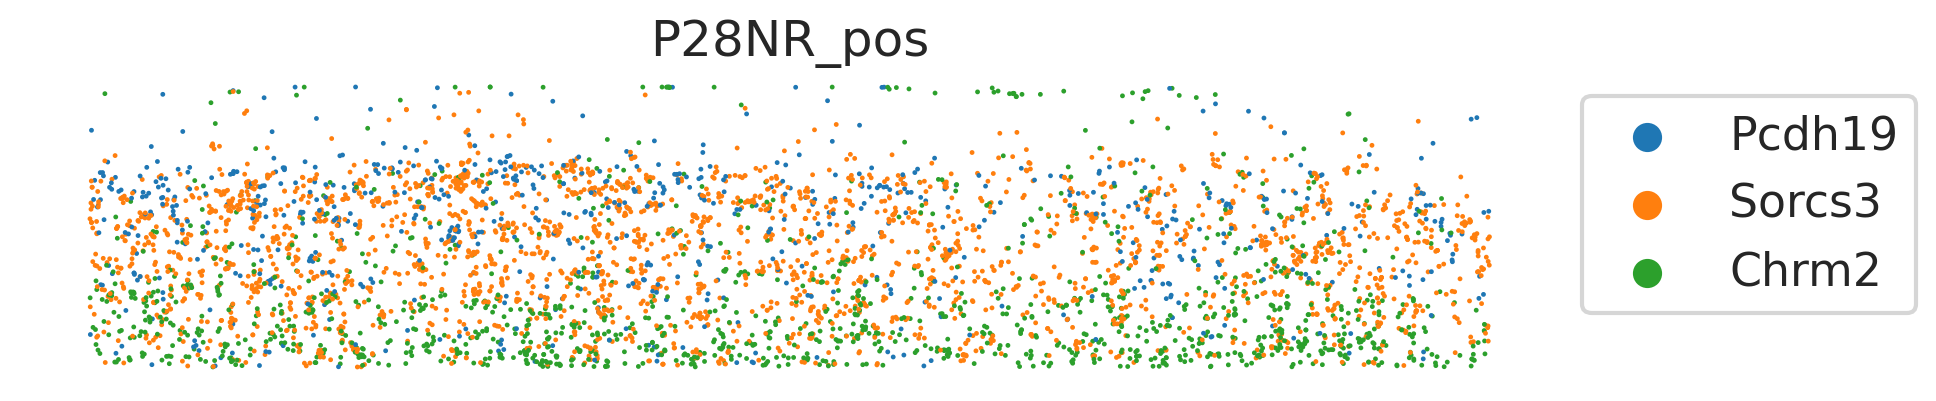

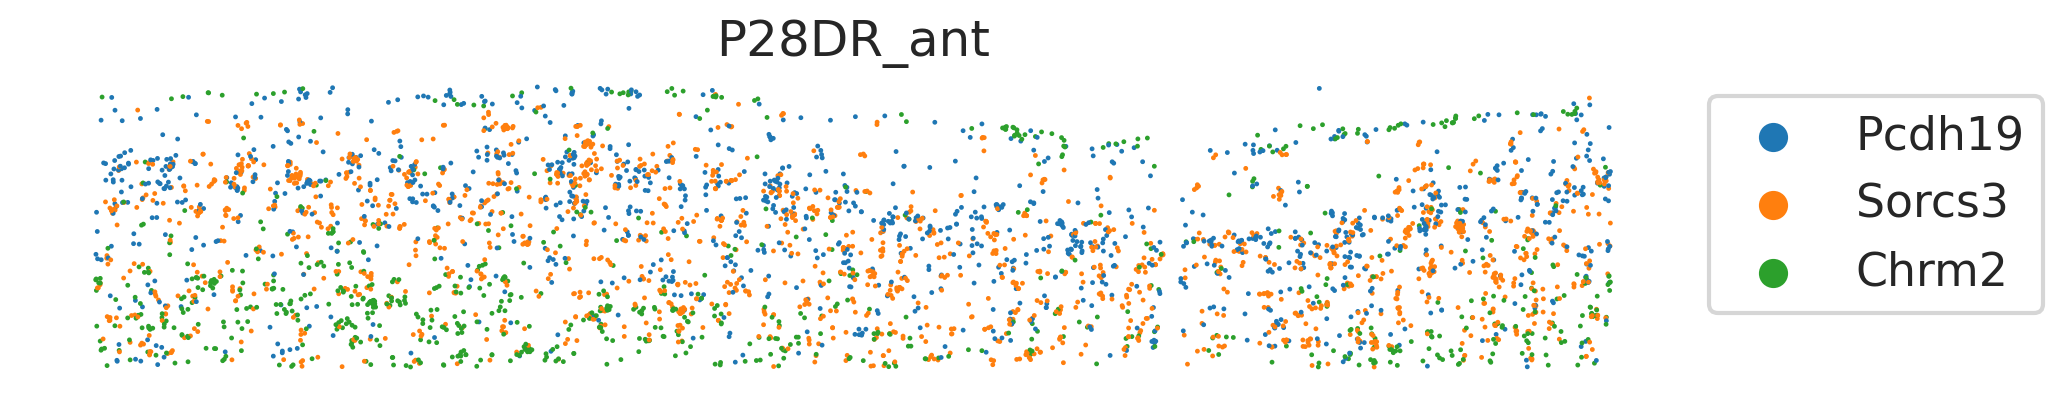

In [10]:
# plot some gene
# query_genes = ['Cdh13', 'Sox5', 'Npas4', 'Sorcs3', 'Grm8', 'Chrm2']
query_genes = ['Pcdh19', 'Sorcs3', 'Chrm2']
for name in ['P28NR_pos', 'P28DR_ant']: #, df in dfs.items():
    df = dfs[name]
    abc = df[df['gene'].isin(query_genes)]
    
    fig, ax = plt.subplots(1,1,figsize=(15,2))
    sns.scatterplot(data=abc.sample(frac=1, replace=False), 
                    x='width', y='depth', hue='gene', hue_order=query_genes, 
                    s=3, edgecolor='none', ax=ax, )
    ax.set_aspect('equal')
    ax.axis('off')
    ax.set_title(name)
    ax.legend(bbox_to_anchor=(1,1))
    ax.invert_yaxis()
    plt.show()

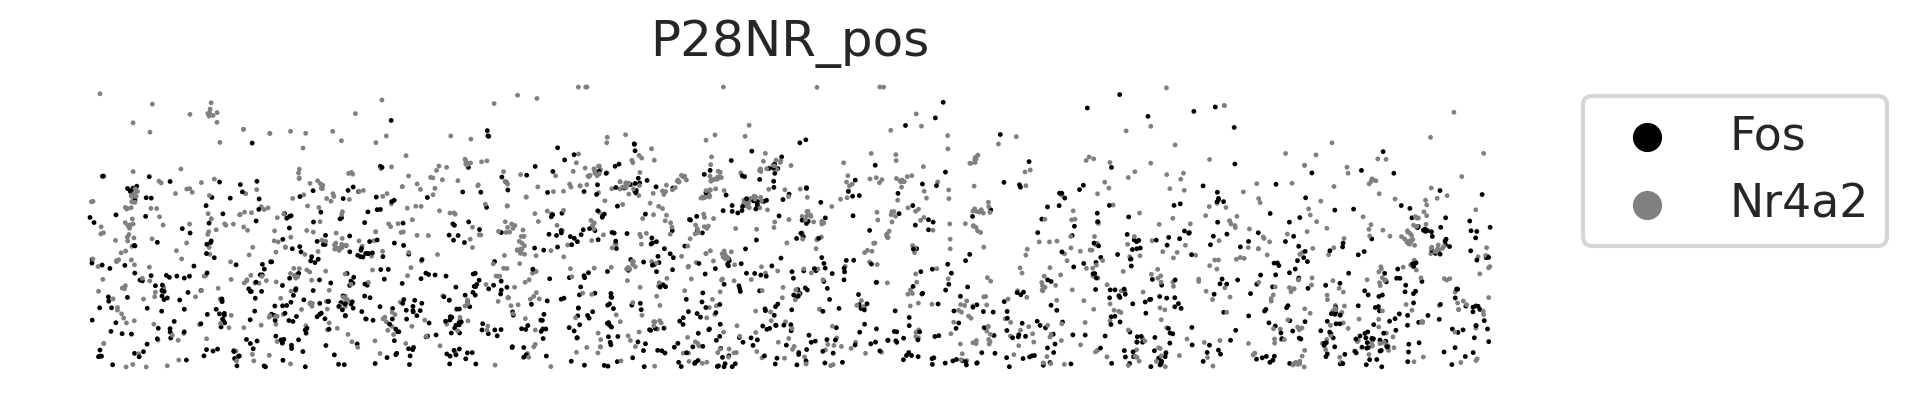

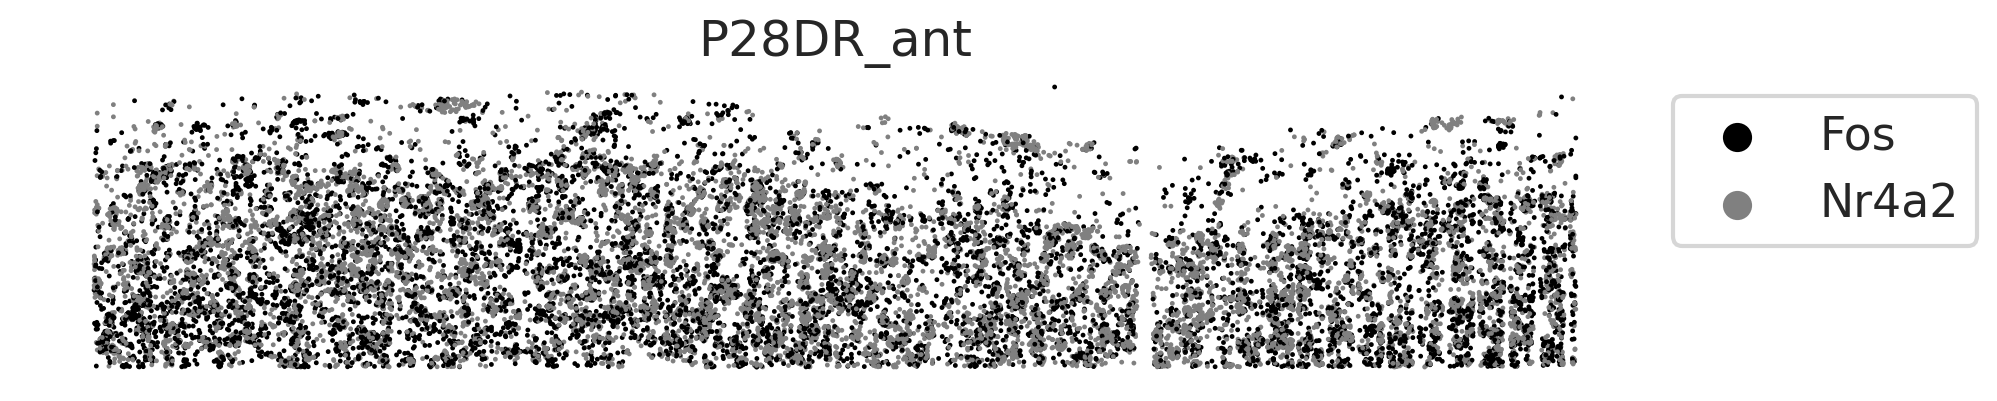

In [11]:
query_genes = ['Fos', 'Nr4a2',]# 'Nr4a3'] # 'Junb']
palette = {
    'Fos': 'k',
    'Nr4a2': 'gray',
}
for name in ['P28NR_pos', 'P28DR_ant']: #, df in dfs.items():
    df = dfs[name]
    abc = df[df['gene'].isin(query_genes)]
    
    fig, ax = plt.subplots(1,1,figsize=(15,2))
    sns.scatterplot(data=abc.sample(frac=1, replace=False), 
                    x='width', y='depth', hue='gene', hue_order=query_genes, 
                    palette=palette,
                    s=3, edgecolor='none', ax=ax, )
    ax.set_aspect('equal')
    ax.axis('off')
    ax.set_title(name)
    ax.legend(bbox_to_anchor=(1,1))
    ax.invert_yaxis()
    plt.show()

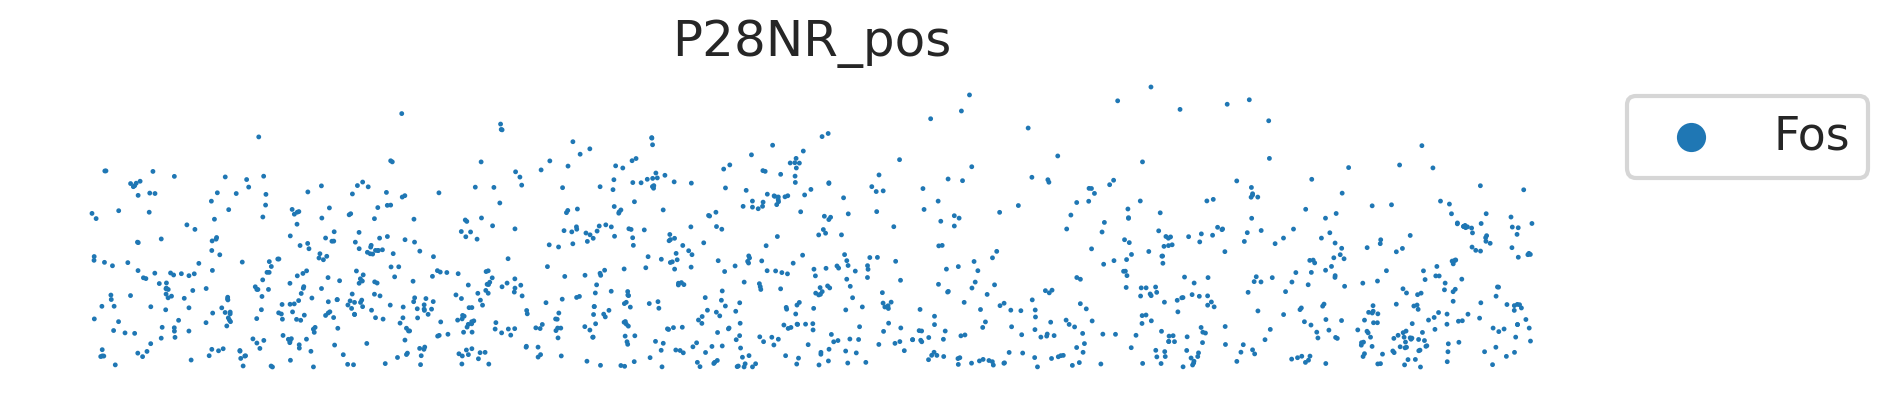

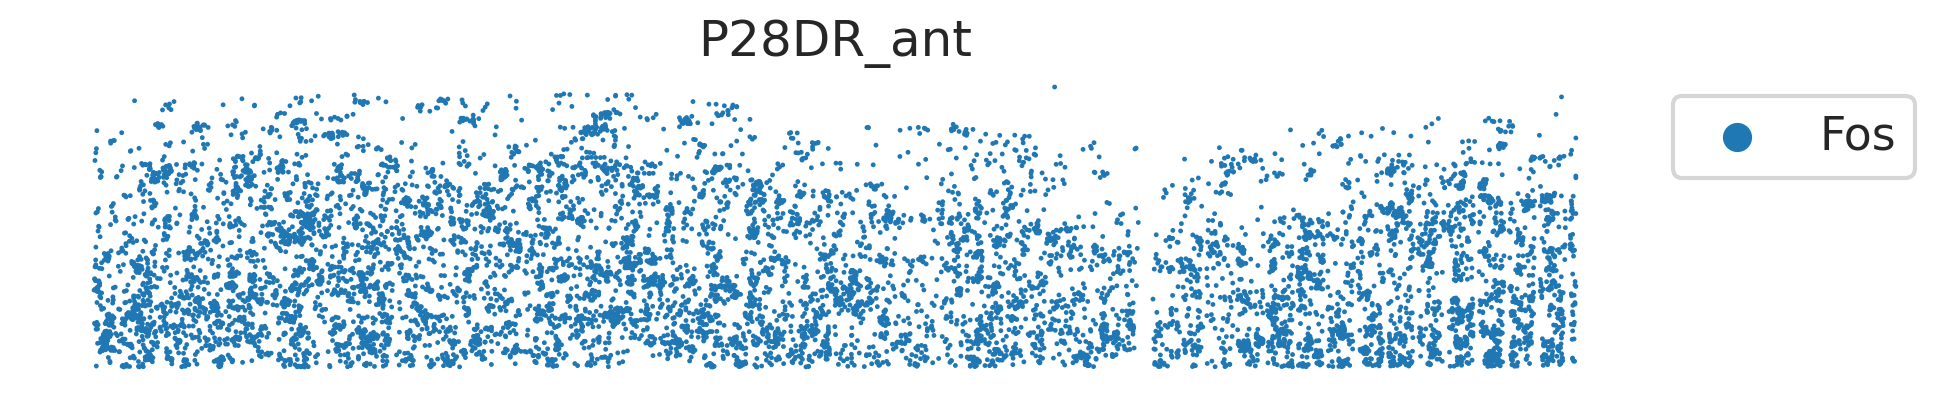

In [12]:
query_genes = ['Fos']
color = 'C3'
for name in ['P28NR_pos', 'P28DR_ant']: #, df in dfs.items():
    df = dfs[name]
    abc = df[df['gene'].isin(query_genes)]
    
    fig, ax = plt.subplots(1,1,figsize=(15,2))
    sns.scatterplot(data=abc.sample(frac=1, replace=False), 
                    x='width', y='depth', hue='gene', hue_order=query_genes, 
                    s=3, edgecolor='none', ax=ax, )
    ax.set_aspect('equal')
    ax.axis('off')
    ax.set_title(name)
    ax.legend(bbox_to_anchor=(1,1))
    ax.invert_yaxis()
    plt.show()

In [13]:
def plot_3genes(query_genes, bins):
    fig, axss = plt.subplots(2,2,figsize=(6*2,4*2))
    for axs, name in zip(axss, ['P28NR_pos', 'P28DR_ant']): #, df in dfs.items():
        df = dfs[name]
        
        width_min = df['width'].min()+200
        width_max = width_min + 700

        abc = df[df['gene'].isin(query_genes)]
        abc = abc[((abc['width']>width_min) & (abc['width']<width_max))]
        abc = abc[((abc['depth']>100) & (abc['depth']<400))]

        ax = axs[0]
        sns.scatterplot(data=abc, x='width', y='depth', hue='gene', hue_order=query_genes, 
                        s=5, edgecolor='none', ax=ax, )
        ax.set_aspect('equal')
        ax.axis('off')
        ax.set_title(name)
        ax.legend(bbox_to_anchor=(1,1))
        ax.invert_yaxis()
        
        ax = axs[1]
        for gn in query_genes:
            hist, _ = np.histogram(abc.loc[abc['gene'].isin([gn]), 'depth'], bins=bins) # , element='step', fill=False, ax=ax, stat='count') # .sample(frac=1, replace=False), 
            ax.plot(bins[1:], hist) #/np.max(hist))
        ax.grid(False)
        sns.despine(ax=ax)
        ax.set_ylabel('Count')
        ax.set_xlabel('Depth')
        
        
    fig.tight_layout()
    plt.show()

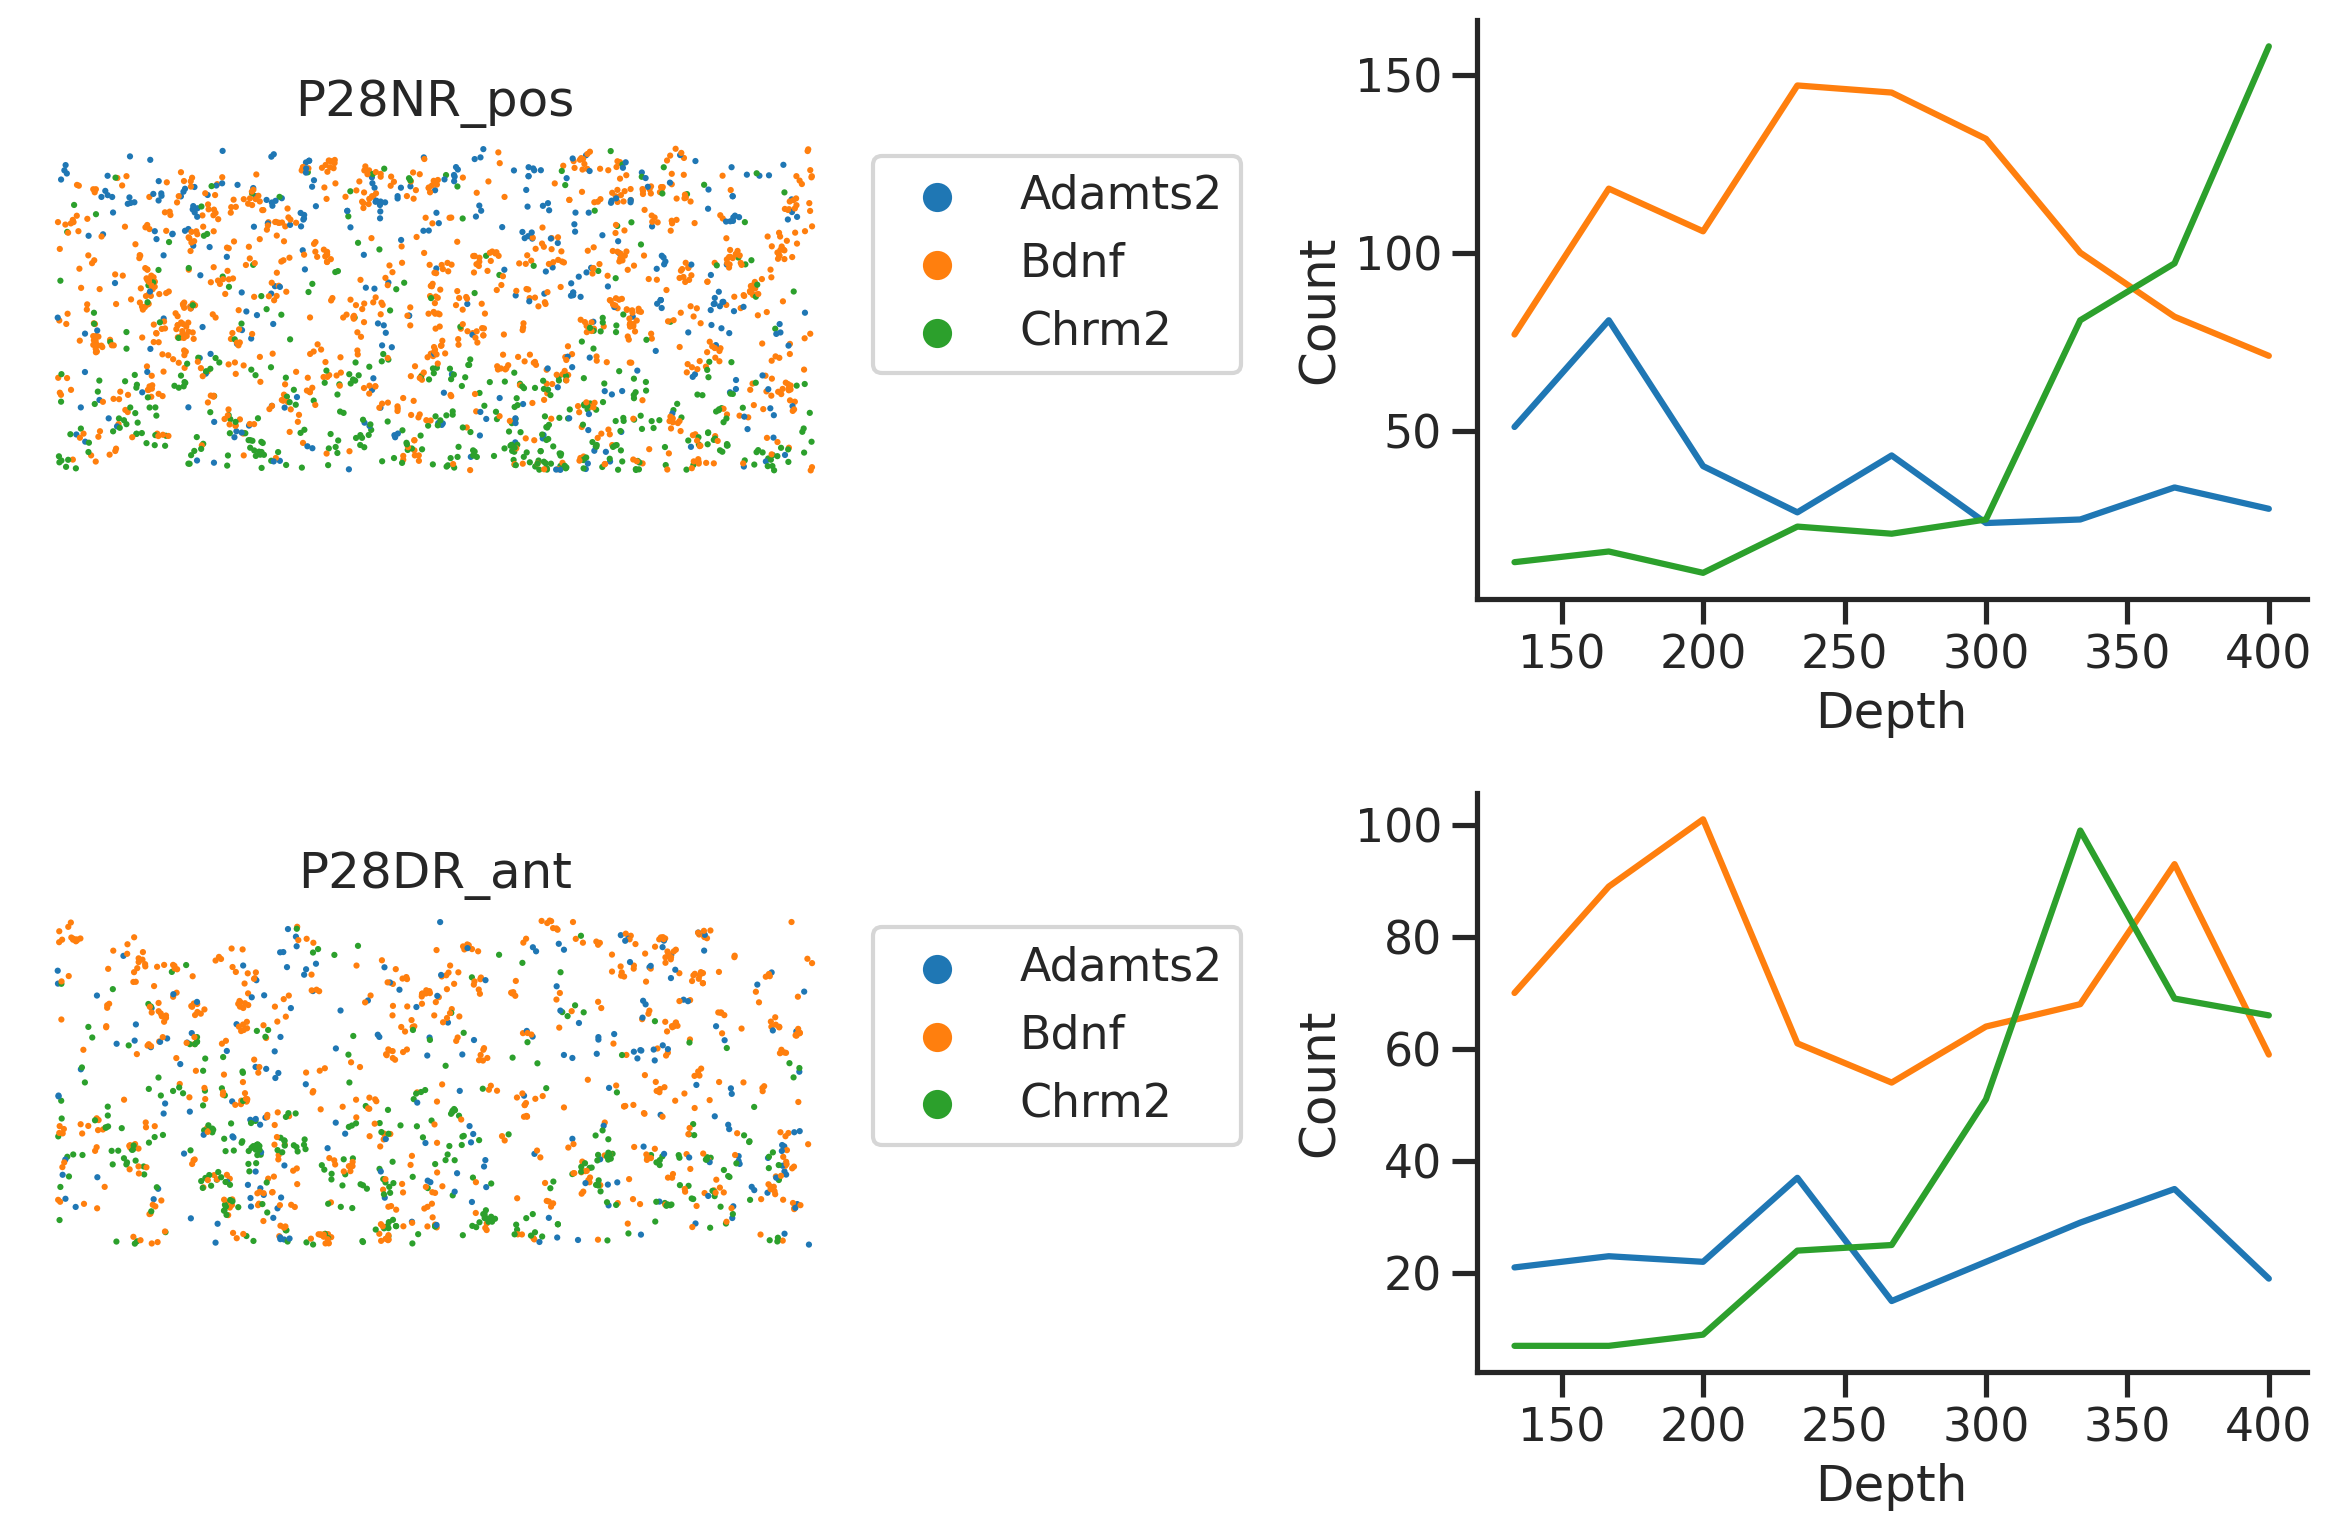

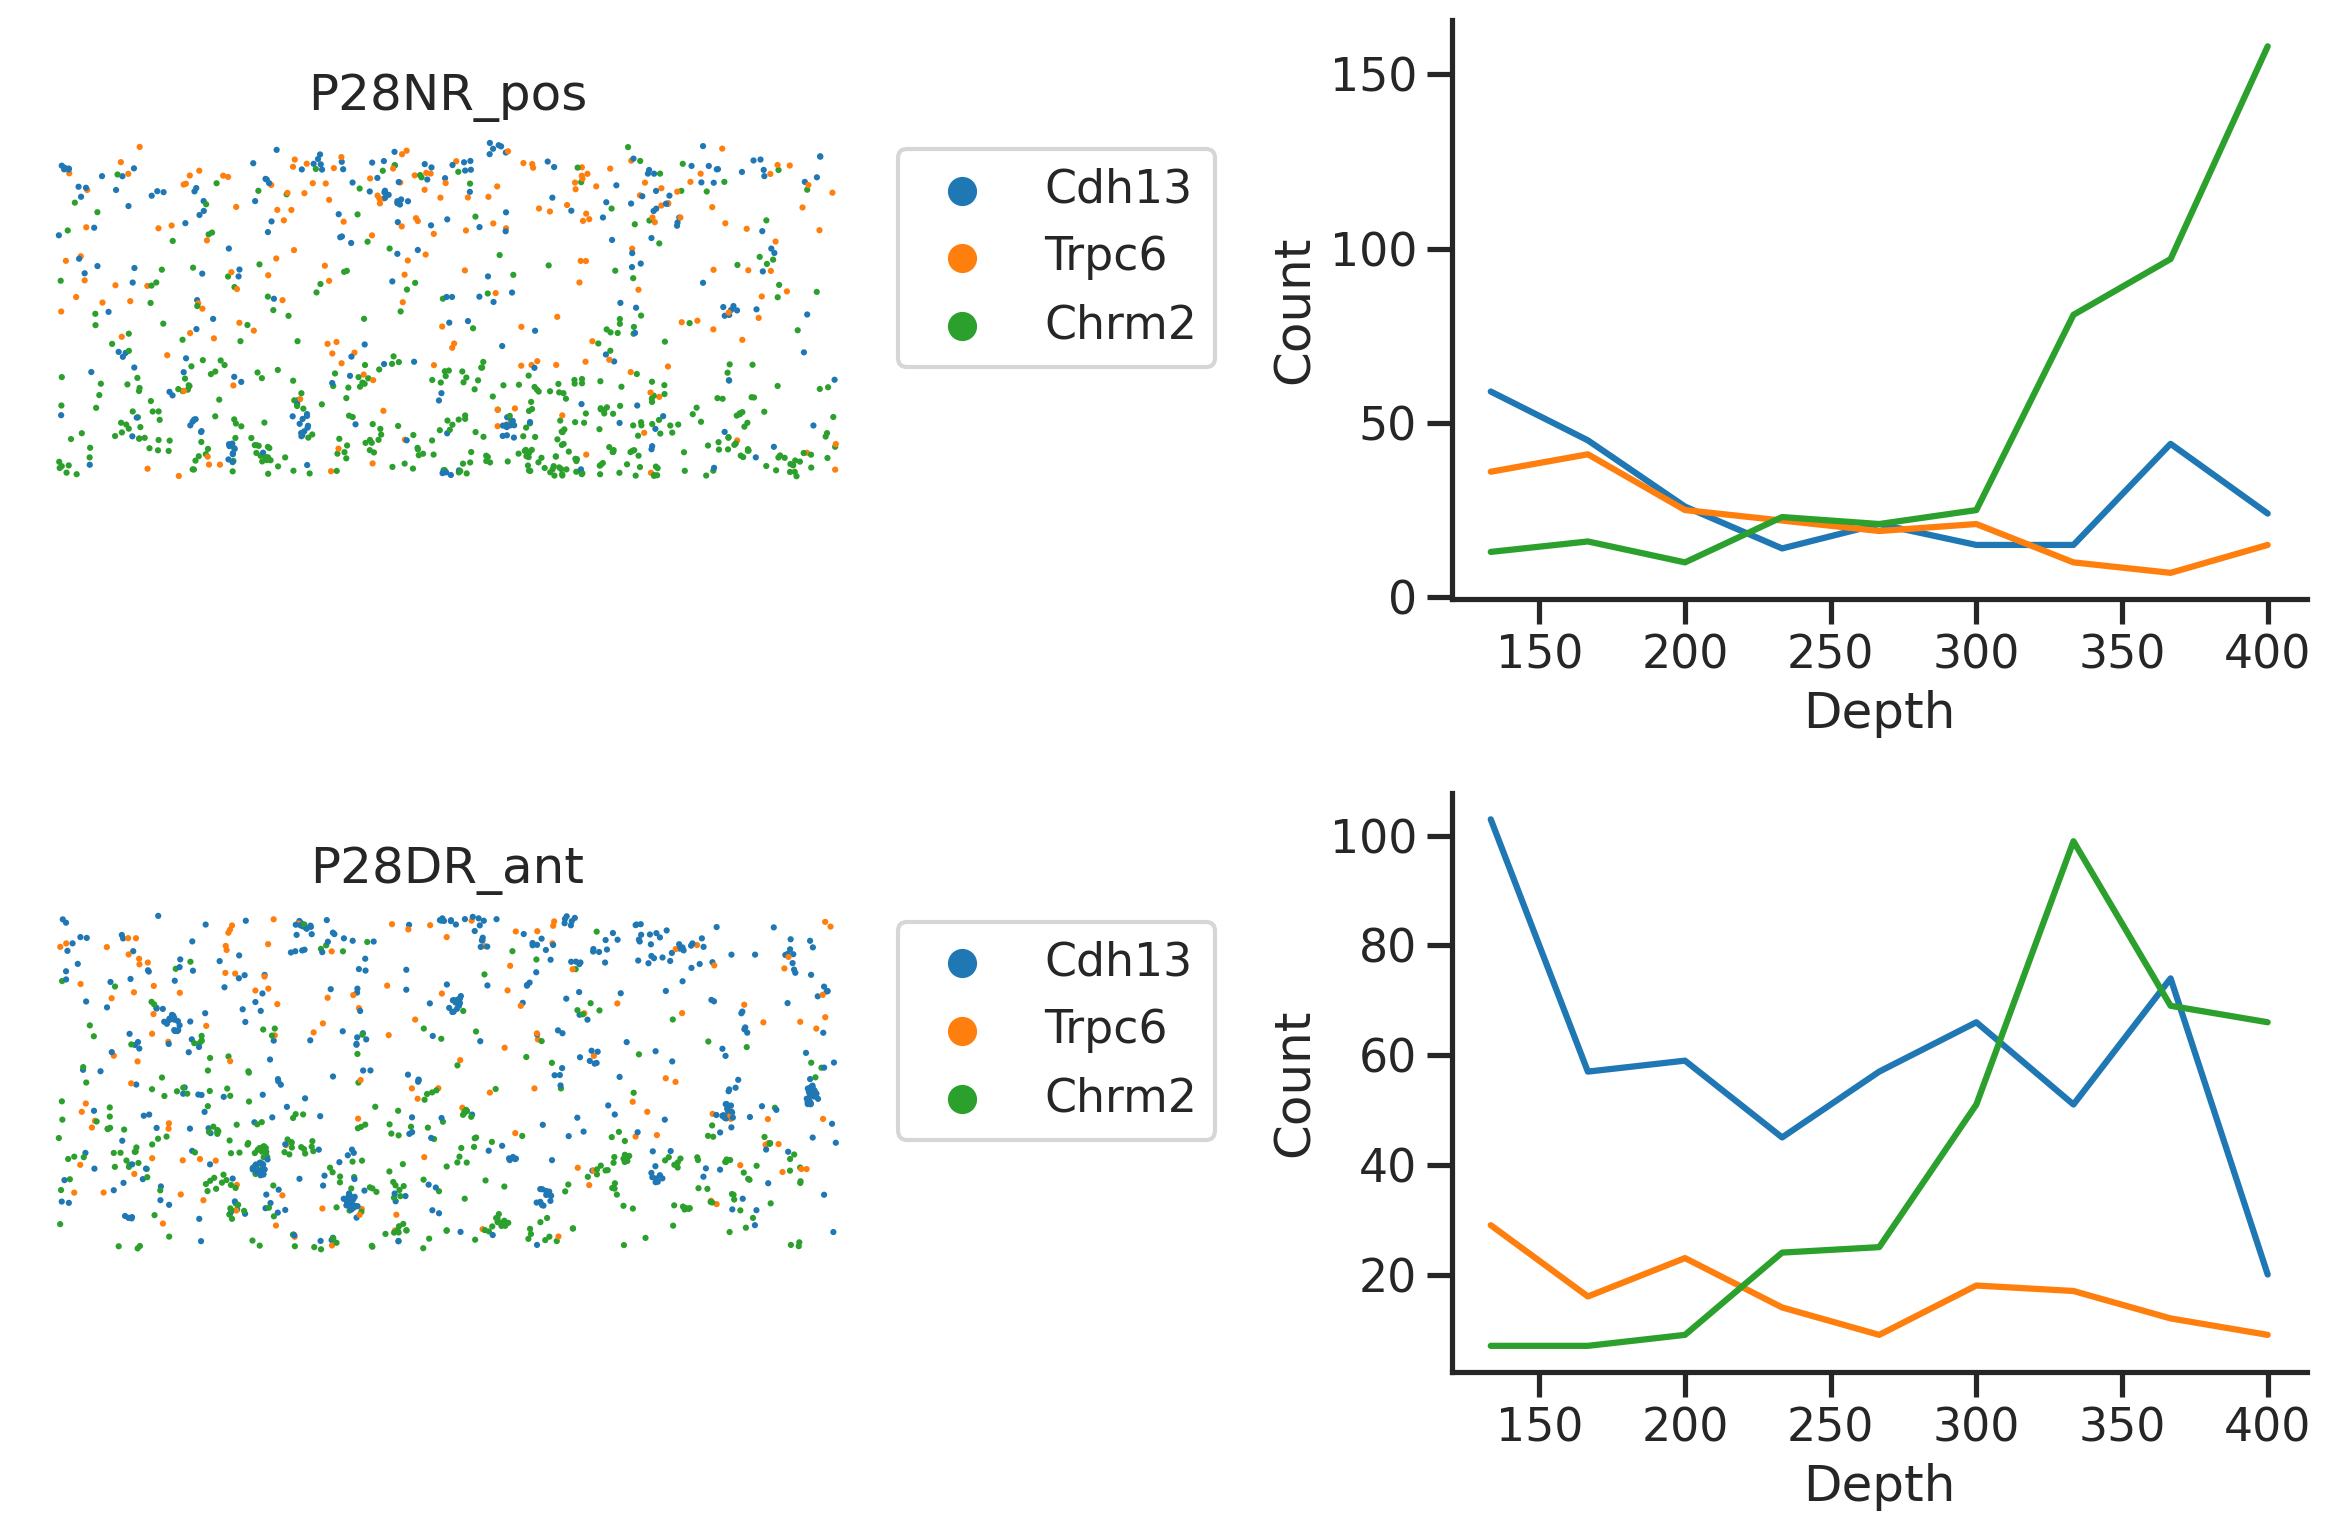

In [14]:
bins = np.linspace(100,400,10)
# query_genes = ['Cdh13', 'Trpc6', 'Chrm2',]
# plot_3genes(query_genes)

# query_genes = ['Pcdh19', 'Sorcs3', 'Cdh12',]
# plot_3genes(query_genes)

query_genes = ['Adamts2', 'Bdnf', 'Chrm2']
plot_3genes(query_genes, bins)

query_genes = ['Cdh13', 'Trpc6', 'Chrm2']
plot_3genes(query_genes, bins)


saved the figure to: /u/home/f/f7xiesnm/project-zipursky/v1-bb/v1/results_merfish/plots_240807/fig3_ieg_imgs_Fos_2024-09-13.pdf


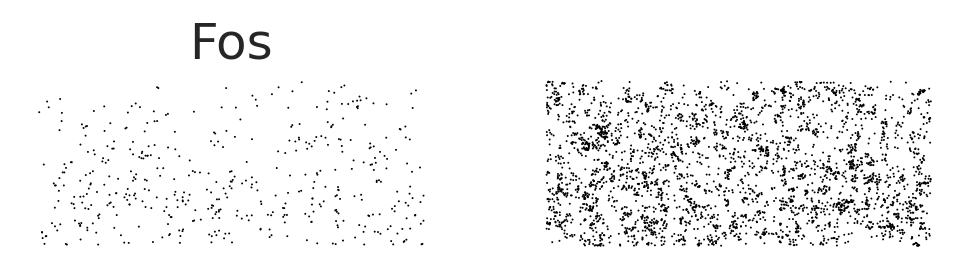

saved the figure to: /u/home/f/f7xiesnm/project-zipursky/v1-bb/v1/results_merfish/plots_240807/fig3_ieg_imgs_Junb_2024-09-13.pdf


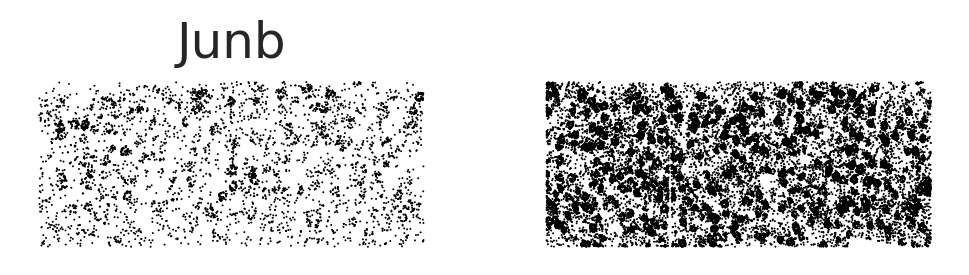

saved the figure to: /u/home/f/f7xiesnm/project-zipursky/v1-bb/v1/results_merfish/plots_240807/fig3_ieg_imgs_Nr4a2_2024-09-13.pdf


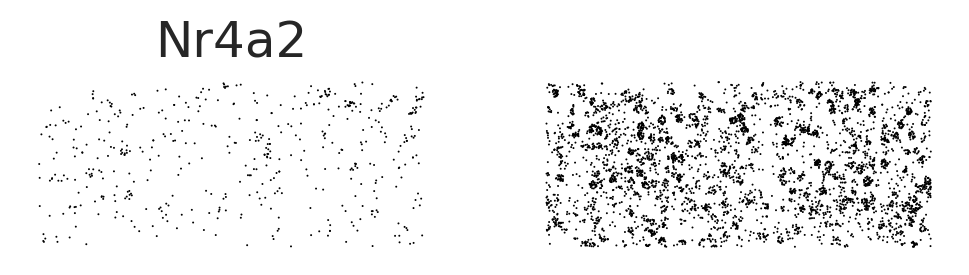

saved the figure to: /u/home/f/f7xiesnm/project-zipursky/v1-bb/v1/results_merfish/plots_240807/fig3_ieg_imgs_Arc_2024-09-13.pdf


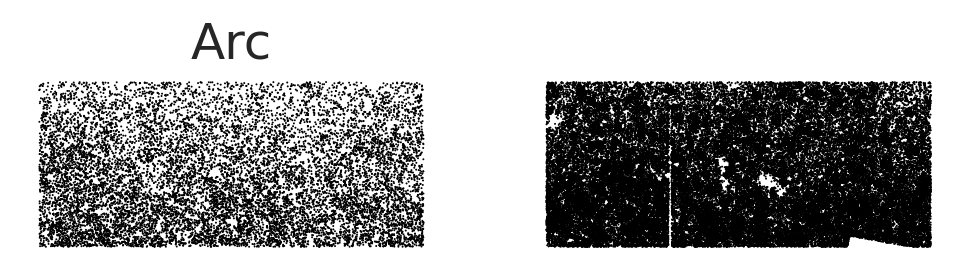

saved the figure to: /u/home/f/f7xiesnm/project-zipursky/v1-bb/v1/results_merfish/plots_240807/fig3_ieg_imgs_Per1_2024-09-13.pdf


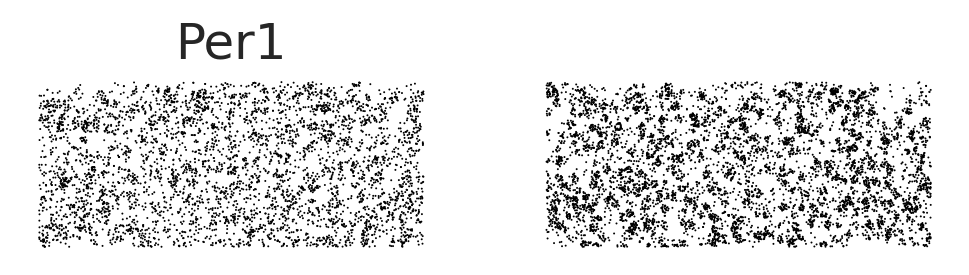

saved the figure to: /u/home/f/f7xiesnm/project-zipursky/v1-bb/v1/results_merfish/plots_240807/fig3_ieg_imgs_Egr4_2024-09-13.pdf


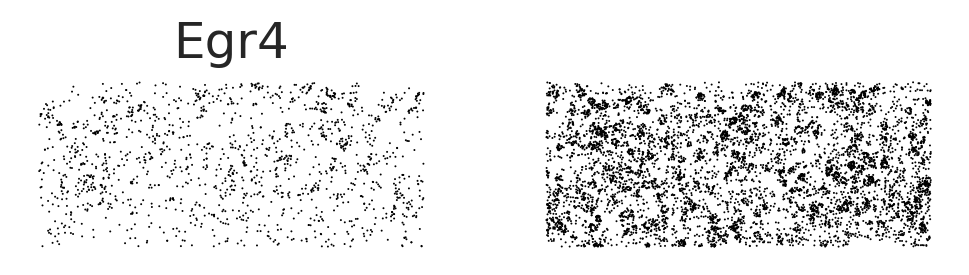

In [15]:
query_genes = ['Fos', 'Junb', 'Nr4a2', 'Arc', 'Per1', 'Egr4',]# ['Pcdh19', 'Cdh13', 'Trpc6', 'Sorcs3', 'Cdh12', 'Chrm2']
for gene in query_genes:
    fig, axs = plt.subplots(1,2,figsize=(3*2,2))
    axs[0].set_title(gene)
    for ax, name in zip(axs, ['P28NR_pos', 'P28DR_ant']): #, df in dfs.items():
        df = dfs[name]
        width_min = df['width'].min()+200
        width_max = width_min + 700
        
        abc = df[df['gene']==gene]
        abc = abc[((abc['width']>width_min) & (abc['width']<width_max))]
        abc = abc[((abc['depth']>100) & (abc['depth']<400))]

        sns.scatterplot(data=abc, x='width', y='depth', 
                        s=0.5, edgecolor='none', ax=ax, color='k', rasterized=True)
        ax.set_aspect('equal')
        ax.axis('off')
        # ax.set_title(name)
        ax.invert_yaxis()
        
    output = os.path.join(outfigdir, f'fig3_ieg_imgs_{gene}.pdf')
    powerplots.savefig_autodate(fig, output)
    plt.show()

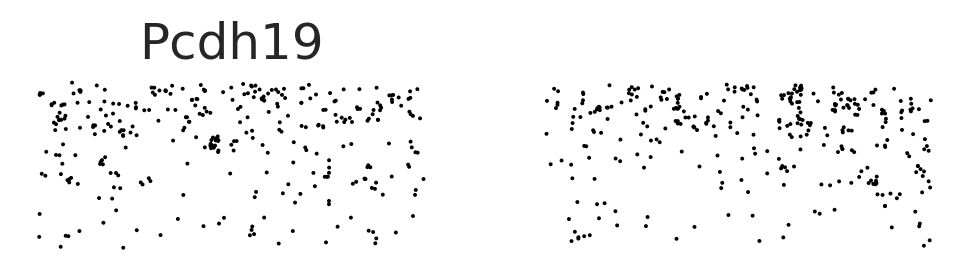

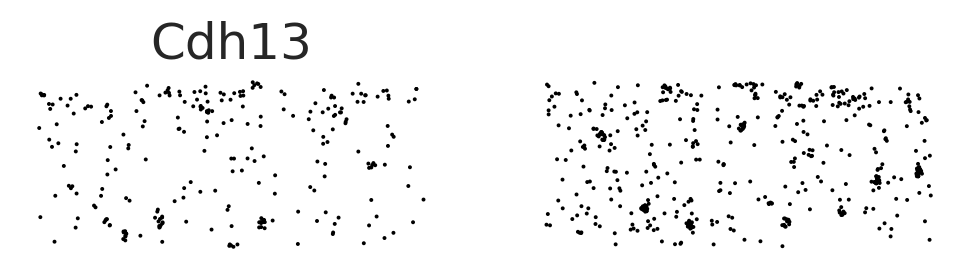

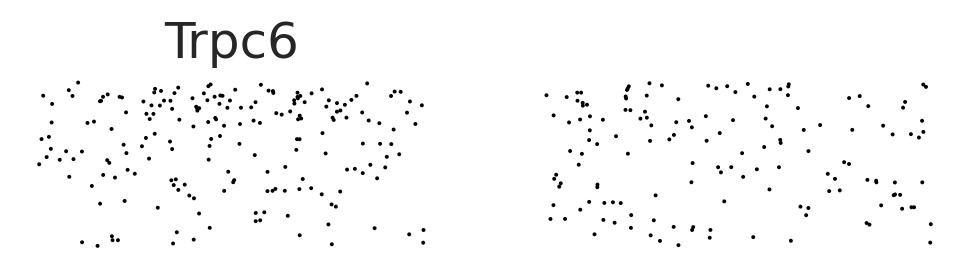

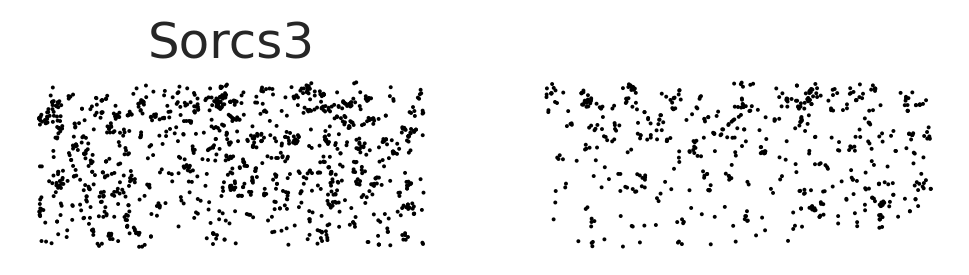

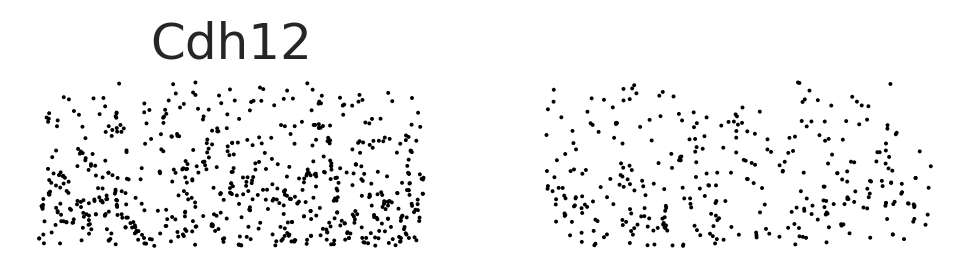

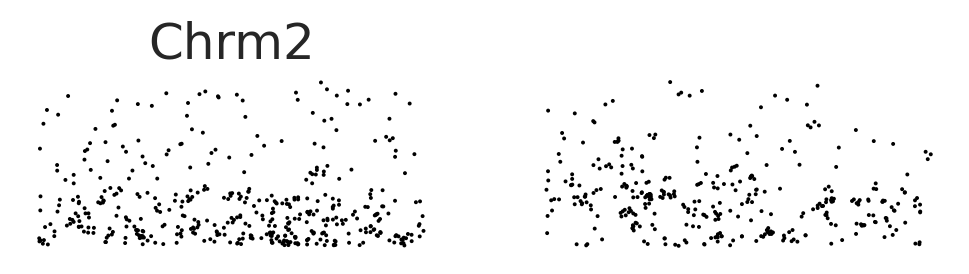

In [16]:
query_genes = ['Pcdh19', 'Cdh13', 'Trpc6', 'Sorcs3', 'Cdh12', 'Chrm2']
# query_genes = ['Matn2', 'Otof', 'Hkdc1', 'Rgs8', 'Lynx1',]
for gene in query_genes:
    fig, axs = plt.subplots(1,2,figsize=(3*2,2))
    axs[0].set_title(gene)
    for ax, name in zip(axs, ['P28NR_pos', 'P28DR_ant']): #, df in dfs.items():
        df = dfs[name]
        abc = df[df['gene']==gene]
        
        width_min = abc['width'].min()+200
        width_max = width_min + 700
        
        abc = abc[((abc['width']>width_min) & (abc['width']<width_max))]
        abc = abc[((abc['depth']>100) & (abc['depth']<400))]

        sns.scatterplot(data=abc, x='width', y='depth', 
                        s=2, edgecolor='none', ax=ax, color='k')
        ax.set_aspect('equal')
        ax.axis('off')
        # ax.set_title(name)
        ax.invert_yaxis()
    plt.show()

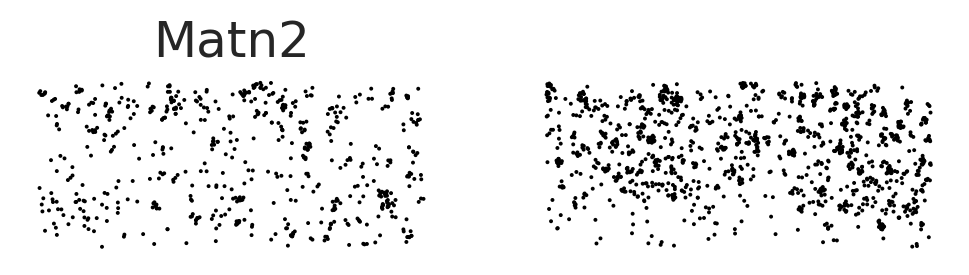

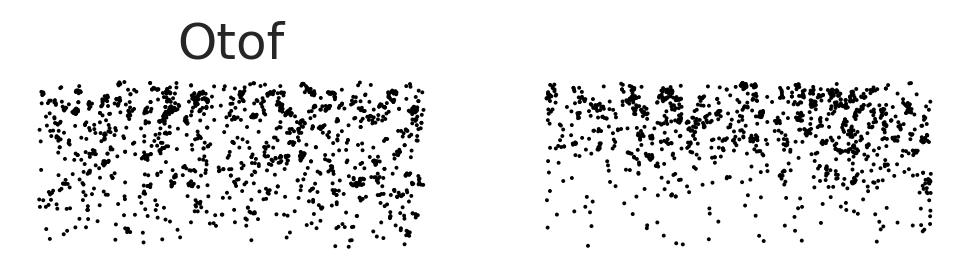

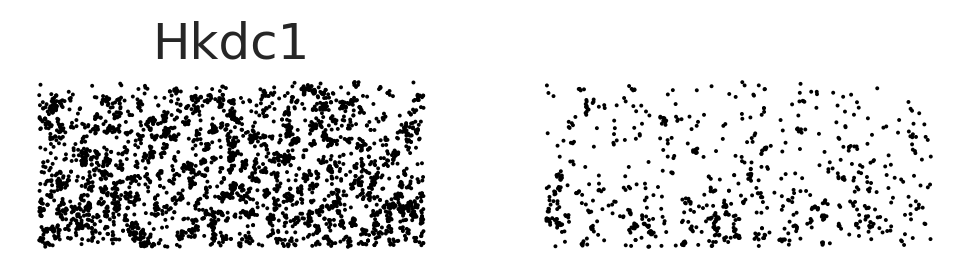

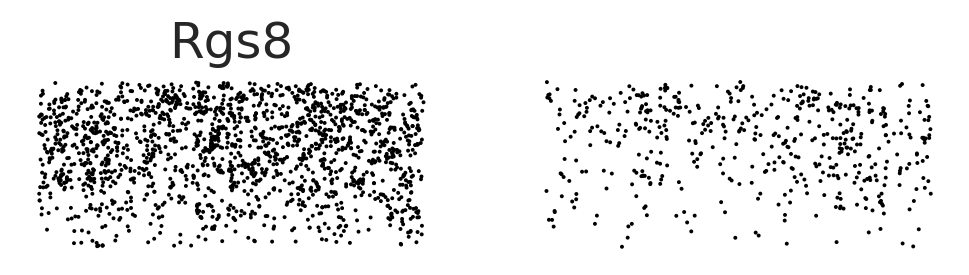

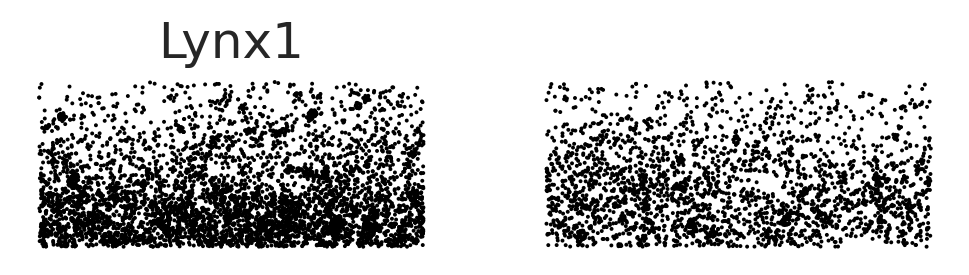

In [17]:
# query_genes = ['Pcdh19', 'Cdh13', 'Trpc6', 'Sorcs3', 'Cdh12', 'Chrm2']
query_genes = ['Matn2', 'Otof', 'Hkdc1', 'Rgs8', 'Lynx1',]
for gene in query_genes:
    fig, axs = plt.subplots(1,2,figsize=(3*2,2))
    axs[0].set_title(gene)
    for ax, name in zip(axs, ['P28NR_pos', 'P28DR_ant']): #, df in dfs.items():
        df = dfs[name]
        abc = df[df['gene']==gene]
        
        width_min = abc['width'].min()+200
        width_max = width_min + 700
        
        abc = abc[((abc['width']>width_min) & (abc['width']<width_max))]
        abc = abc[((abc['depth']>100) & (abc['depth']<400))]

        sns.scatterplot(data=abc, x='width', y='depth', 
                        s=2, edgecolor='none', ax=ax, color='k')
        ax.set_aspect('equal')
        ax.axis('off')
        # ax.set_title(name)
        ax.invert_yaxis()
    plt.show()

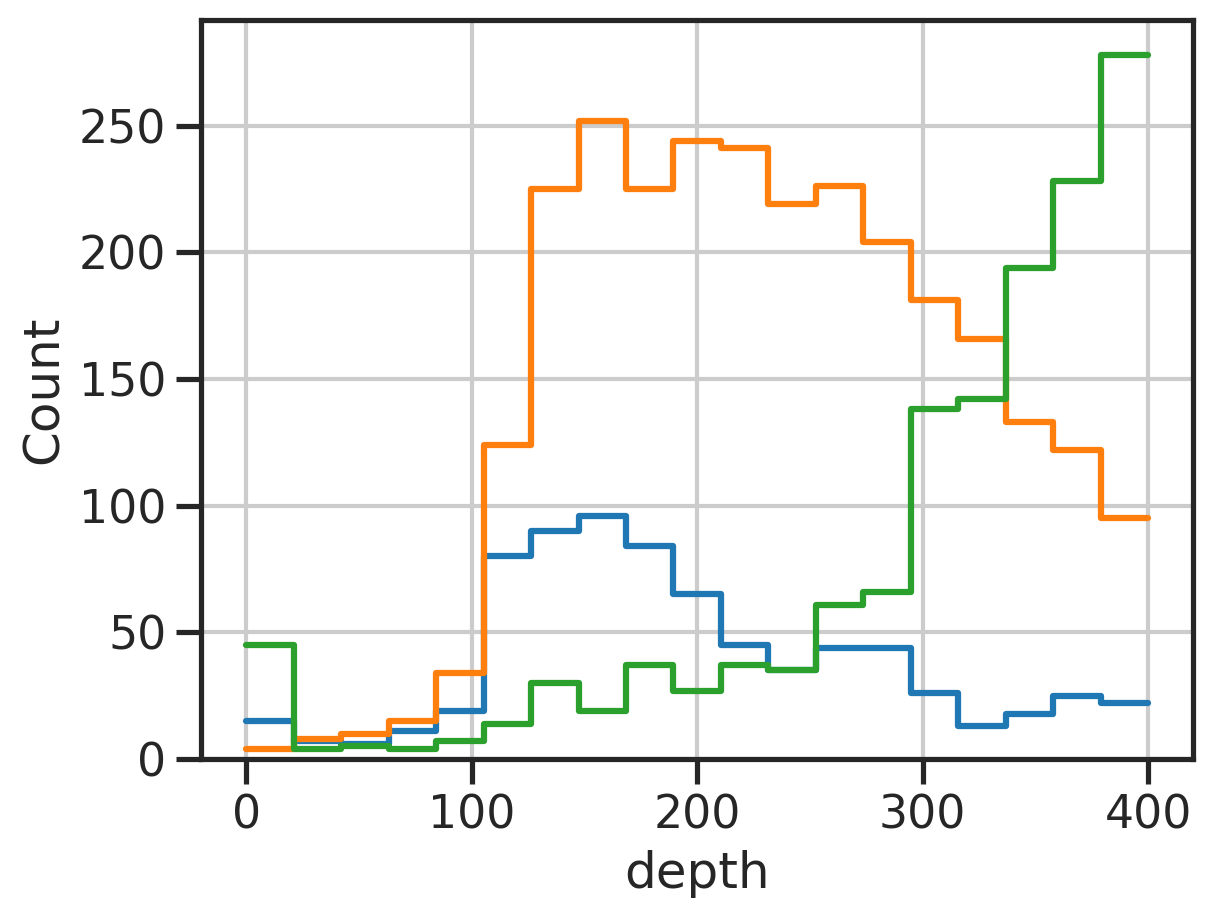

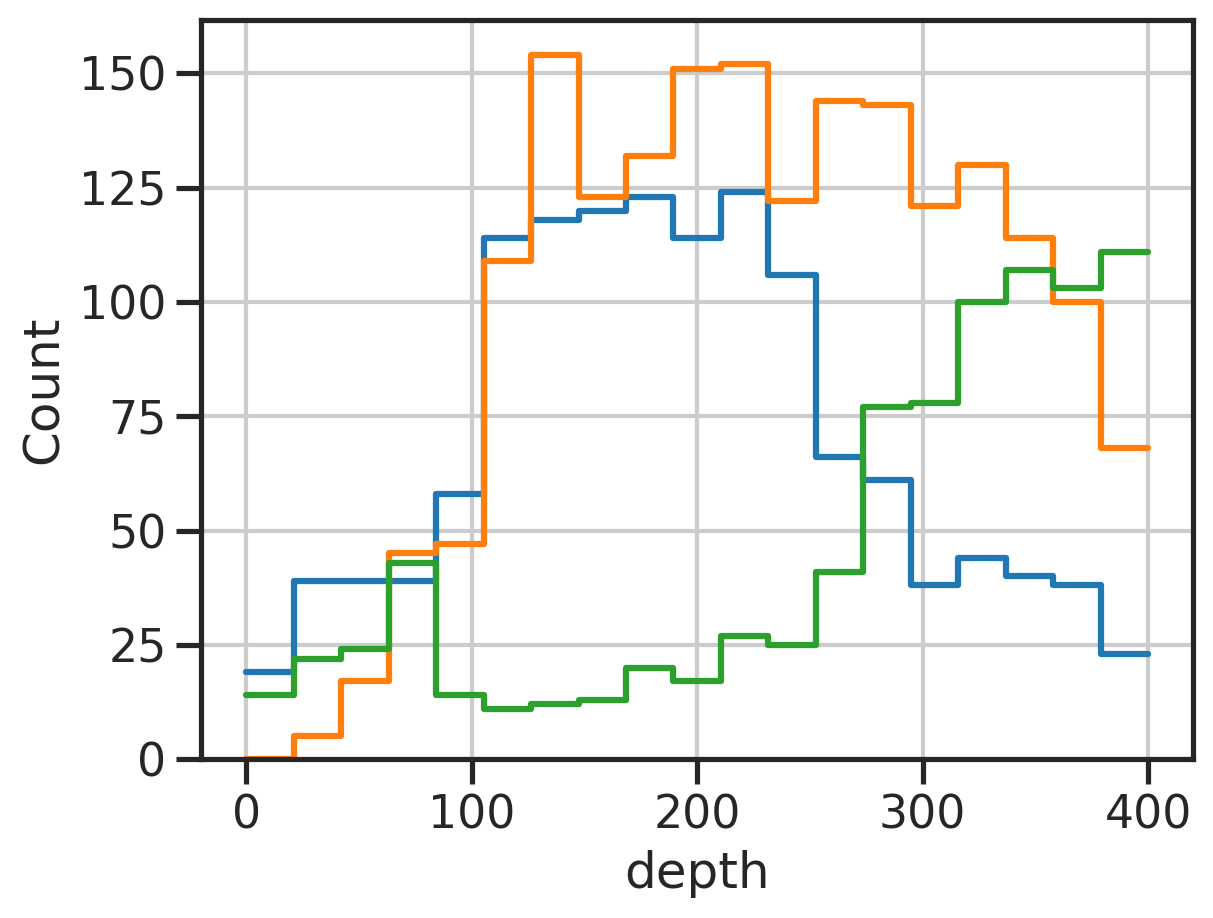

In [18]:
bins = np.linspace(0,400,20)
query_genes = ['Pcdh19', 'Sorcs3', 'Chrm2']
df = dfs['P28NR_pos']
for gn in query_genes:
    sns.histplot(df.loc[df['gene'].isin([gn]), 'depth'], bins=bins, element='step', fill=False) # .sample(frac=1, replace=False), 
plt.show()
            
df = dfs['P28DR_ant']
for gn in query_genes:
    sns.histplot(df.loc[df['gene'].isin([gn]), 'depth'], bins=bins, element='step', fill=False) # .sample(frac=1, replace=False), 
plt.show()
                    # x='width', y='depth', hue='gene', hue_order=query_genes, 
                    # s=4, edgecolor='none', ax=ax, )

In [19]:
# # query_genes = ['Cdh13', 'Pcdh19', 'Rfx3', ]
# # query_genes = ['Sema6a', 'Gabrg3']
# # query_genes = ['Cdh13', 'Sox5', 'Chrm2', ]
# query_genes = ['Pcdh19', 'Pcdh15']
# for name, df in dfs.items():
#     abc = df[df['gene'].isin(query_genes)]
    
#     fig, ax = plt.subplots(1,1,figsize=(12,3))
#     sns.scatterplot(data=abc.sample(frac=1, replace=False), 
#                     x='width', y='depth', hue='gene', hue_order=query_genes, 
#                     s=4, edgecolor='none', ax=ax, )
#     ax.set_aspect('equal')
#     ax.axis('off')
#     ax.set_title(name)
#     ax.legend(bbox_to_anchor=(1,1))
#     ax.invert_yaxis()

# histogram analysis

In [20]:
sns.color_palette('tab20c')

[(0.19215686274509805, 0.5098039215686274, 0.7411764705882353),
 (0.4196078431372549, 0.6823529411764706, 0.8392156862745098),
 (0.6196078431372549, 0.792156862745098, 0.8823529411764706),
 (0.7764705882352941, 0.8588235294117647, 0.9372549019607843),
 (0.9019607843137255, 0.3333333333333333, 0.050980392156862744),
 (0.9921568627450981, 0.5529411764705883, 0.23529411764705882),
 (0.9921568627450981, 0.6823529411764706, 0.4196078431372549),
 (0.9921568627450981, 0.8156862745098039, 0.6352941176470588),
 (0.19215686274509805, 0.6392156862745098, 0.32941176470588235),
 (0.4549019607843137, 0.7686274509803922, 0.4627450980392157),
 (0.6313725490196078, 0.8509803921568627, 0.6078431372549019),
 (0.7803921568627451, 0.9137254901960784, 0.7529411764705882),
 (0.4588235294117647, 0.4196078431372549, 0.6941176470588235),
 (0.6196078431372549, 0.6039215686274509, 0.7843137254901961),
 (0.7372549019607844, 0.7411764705882353, 0.8627450980392157),
 (0.8549019607843137, 0.8549019607843137, 0.9215686274509803),
 (0.38823529411764707, 0.38823529411764707, 0.38823529411764707),
 (0.5882352941176471, 0.5882352941176471, 0.5882352941176471),
 (0.7411764705882353, 0.7411764705882353, 0.7411764705882353),
 (0.8509803921568627, 0.8509803921568627, 0.8509803921568627)]

In [21]:
linestyles = {
    'P28NR_ant': '-',
    'P28NR_pos': '-',
    'P28DR_ant': '--',
}

colors = {
    'P28NR_pos': sns.color_palette('tab20c')[5],
    'P28NR_ant': sns.color_palette('tab20c')[6],
    
    'P28DR_ant': 'k',
}

bins = np.linspace(100,400,15)
midpoints = np.mean([bins[:-1], bins[1:]], axis=0)

In [22]:
# size normed counts by depth
df_dbins = {}
for name in names:
    df = dfs[name].copy()
    width_min = df['width'].min() + 200
    width_max = width_min + 700

    df = df[((df['width']>width_min) & (df['width']<width_max))]
    df = df[((df['depth']>100) & (df['depth']<400))]
    
    df['depth_bin'] = pd.cut(df['depth'].values, bins=bins)
    df_dbin = df.groupby(['depth_bin', 'gene']).size().unstack()
    df_dbins[name] = df_dbin # /area_factors[name]

In [23]:
# # ref point for each gene - mean normed counts across all L2/3 in NR
# gene_mean_refs = pd.concat([
#     df_dbins['P28NR_pos'].mean(), 
#     df_dbins['P28NR_ant'].mean()], 
#     axis=1).mean(axis=1)

# # gene expression as the fold change relative to the reference point
# df_dbin_fcs = {}
# for name in names:
#     df_dbin = df_dbins[name]
#     df_dbin_fc = df_dbin/gene_mean_refs
#     df_dbin_fcs[name] = df_dbin_fc

saved the figure to: /u/home/f/f7xiesnm/project-zipursky/v1-bb/v1/results_merfish/plots_240807/fig3_ieg_lines_2024-09-13.pdf


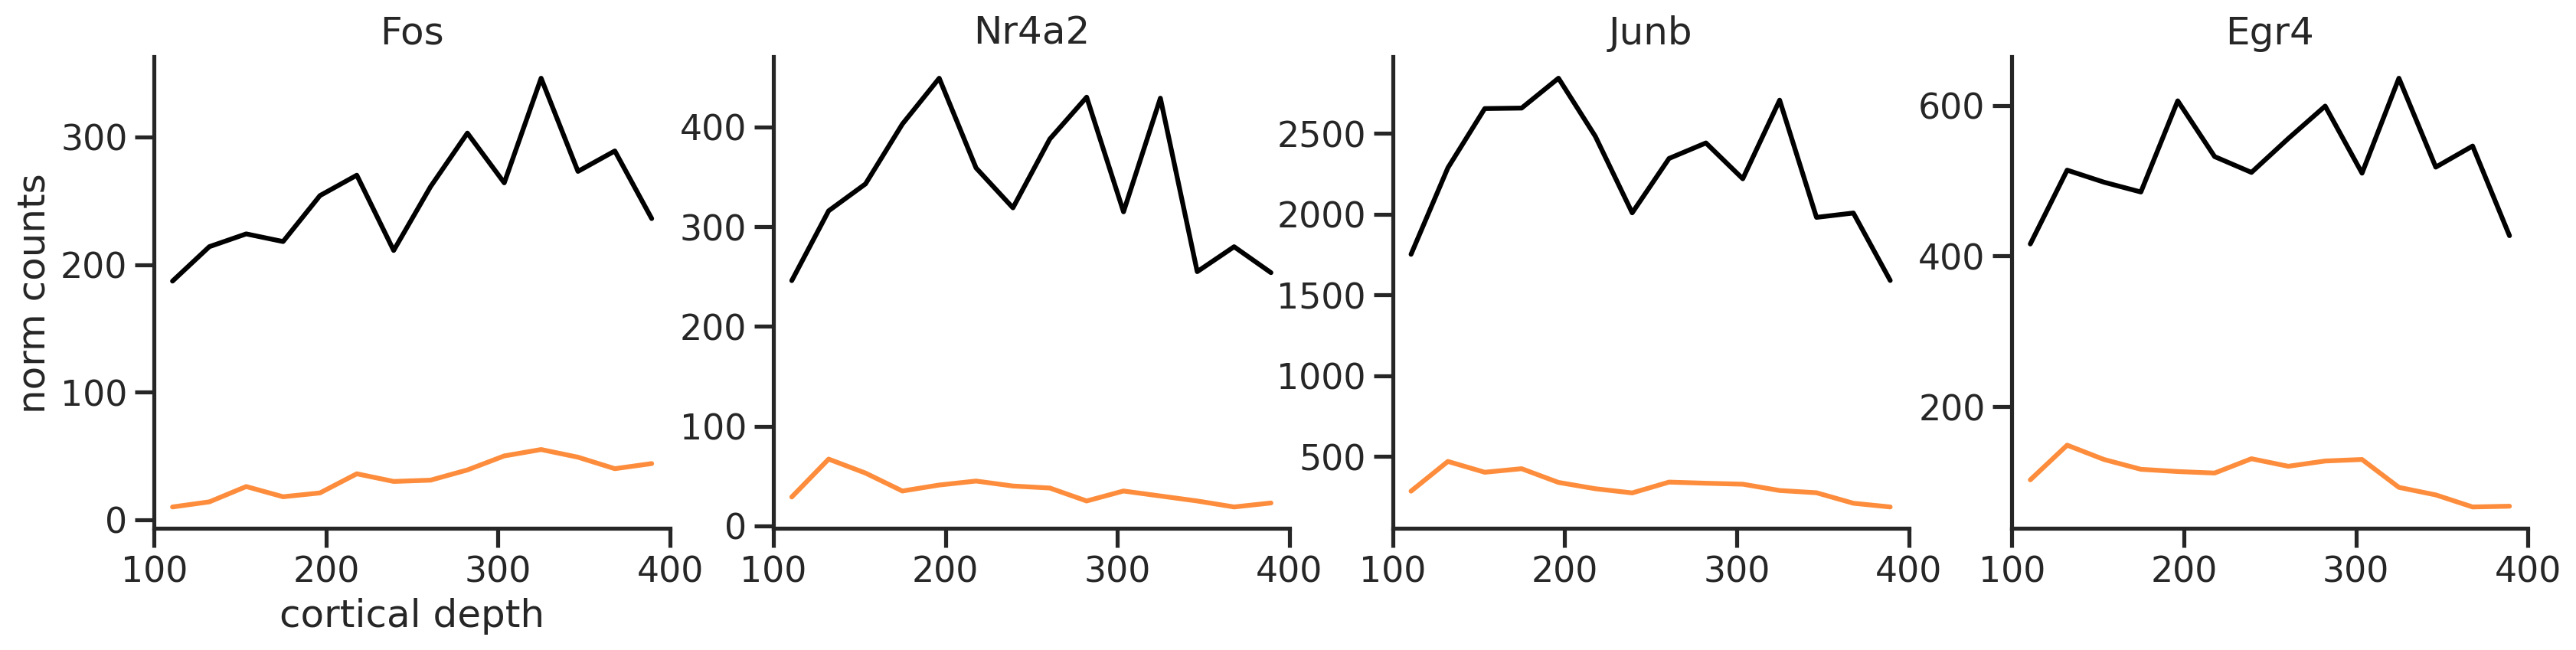

In [24]:
query_genes = ['Fos', 'Nr4a2', 'Junb', 'Egr4',]
samples = ['P28NR_pos', 'P28DR_ant']
n = len(query_genes)

fig, axs = plt.subplots(1, n, figsize=(n*5,1*4), sharex=True, sharey=False)
ax = axs[0]
ax.set_ylabel('norm counts')
ax.set_xlabel('cortical depth')

for j, gene in enumerate(query_genes):
    ax = axs[j]
    ax.set_title(gene)
    for i, name in enumerate(samples):
        color = colors[name]
        hist_norm  = df_dbins[name][gene]
        ax.plot(midpoints, hist_norm, 
                color=color, label=name)
        sns.despine(ax=ax)
    ax.set_xlim([100,400])
    ax.grid(False)

output = os.path.join(outfigdir, 'fig3_ieg_lines.pdf')
powerplots.savefig_autodate(fig, output)
# ax.legend()
plt.show()

saved the figure to: /u/home/f/f7xiesnm/project-zipursky/v1-bb/v1/results_merfish/plots_240807/fig3_typegene_lines_2024-09-13.pdf


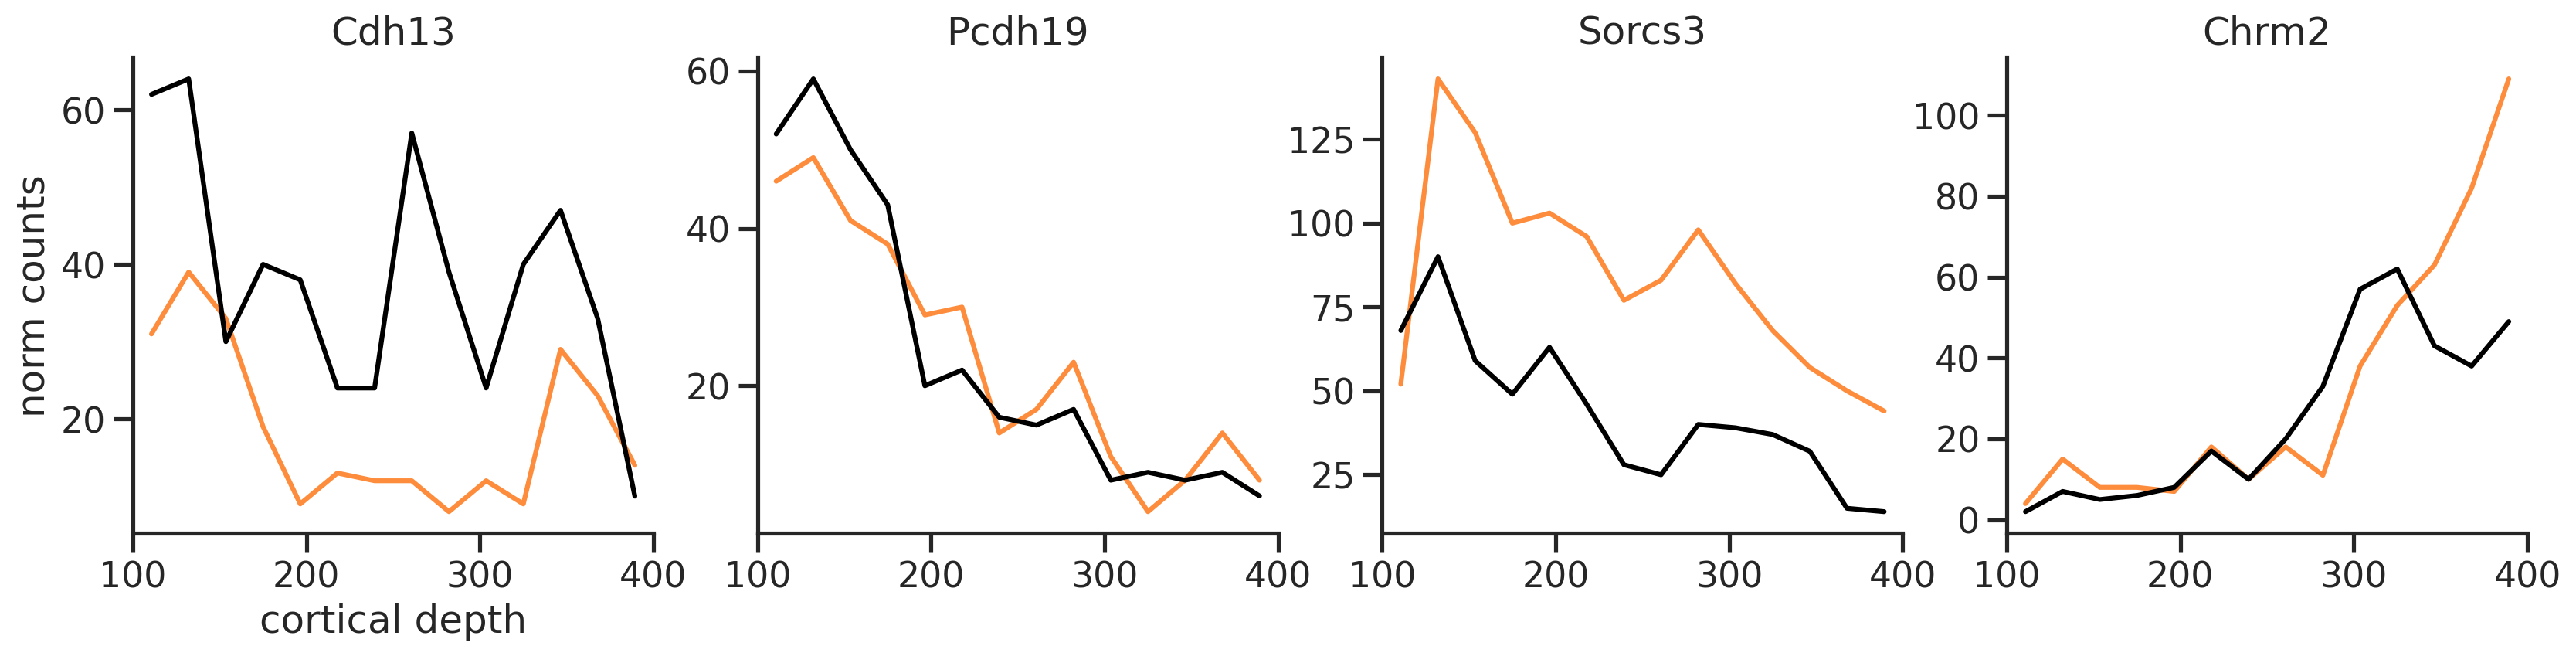

In [25]:
query_genes = ['Cdh13', 'Pcdh19', 'Sorcs3', 'Chrm2']
samples = ['P28NR_pos', 'P28DR_ant']
n = len(query_genes)

fig, axs = plt.subplots(1, n, figsize=(n*5,1*4), sharex=True, sharey=False)
ax = axs[0]
ax.set_ylabel('norm counts')
ax.set_xlabel('cortical depth')

for j, gene in enumerate(query_genes):
    ax = axs[j]
    ax.set_title(gene)
    for i, name in enumerate(samples):
        color = colors[name]
        hist_norm  = df_dbins[name][gene]
        ax.plot(midpoints, hist_norm, 
                color=color, label=name)
        sns.despine(ax=ax)
    ax.set_xlim([100,400])
    ax.grid(False)

output = os.path.join(outfigdir, 'fig3_typegene_lines.pdf')
powerplots.savefig_autodate(fig, output)
# ax.legend()
plt.show()

saved the figure to: /u/home/f/f7xiesnm/project-zipursky/v1-bb/v1/results_merfish/plots_240807/fig3_typegene_lines_2024-09-13.pdf


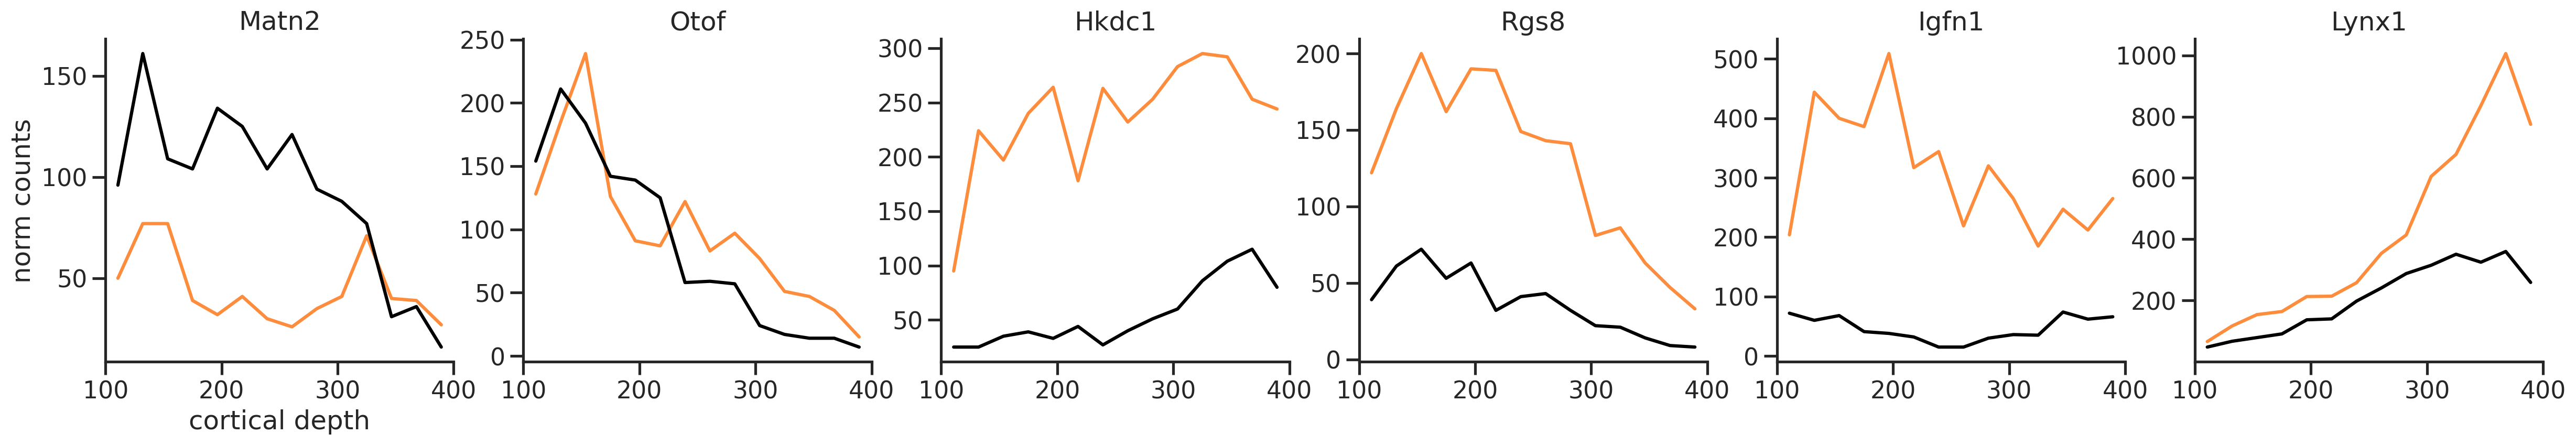

In [26]:
# query_genes = ['Cdh13', 'Pcdh19', 'Sorcs3', 'Chrm2']
query_genes = ['Matn2', 'Otof', 'Hkdc1', 'Rgs8', 'Igfn1', 'Lynx1']
samples = ['P28NR_pos', 'P28DR_ant']
n = len(query_genes)

fig, axs = plt.subplots(1, n, figsize=(n*5,1*4), sharex=True, sharey=False)
ax = axs[0]
ax.set_ylabel('norm counts')
ax.set_xlabel('cortical depth')

for j, gene in enumerate(query_genes):
    ax = axs[j]
    ax.set_title(gene)
    for i, name in enumerate(samples):
        color = colors[name]
        hist_norm  = df_dbins[name][gene]
        ax.plot(midpoints, hist_norm, 
                color=color, label=name)
        sns.despine(ax=ax)
    ax.set_xlim([100,400])
    ax.grid(False)

output = os.path.join(outfigdir, 'fig3_typegene_lines.pdf')
powerplots.savefig_autodate(fig, output)
# ax.legend()
plt.show()

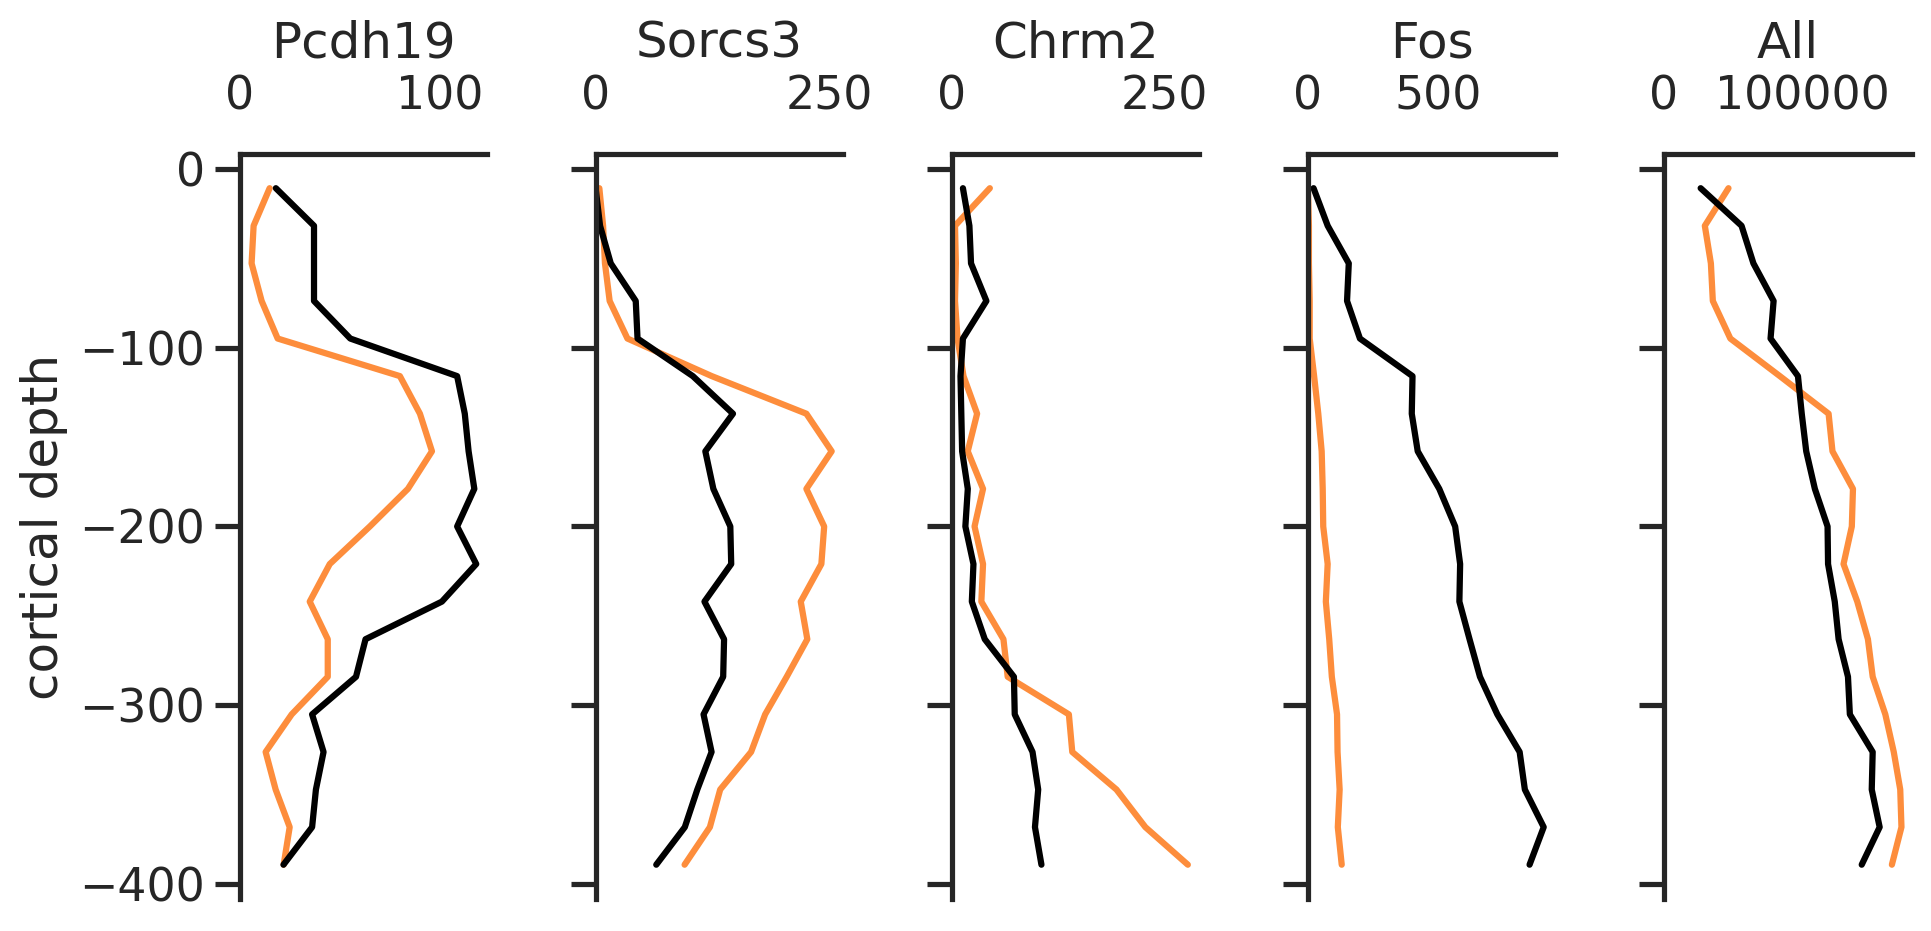

In [22]:
query_genes = ['Pcdh19', 'Sorcs3', 'Chrm2', 'Fos', 'All']
samples = ['P28NR_pos', 'P28DR_ant']
fig, axs = plt.subplots(1, 5, figsize=(5*2,1*5), sharex=False, sharey=True)
ax = axs[0]
# ax.set_xlabel('norm counts')
ax.set_ylabel('cortical depth')

for j, gene in enumerate(query_genes):
    ax = axs[j]
    ax.set_title(gene)
    for i, name in enumerate(samples):
        color = colors[name]
        if gene == 'All':
            hist_norm = df_dbins[name].sum(axis=1)
        else:
            hist_norm  = df_dbins[name][gene]
        ax.plot(hist_norm, -midpoints,  
                color=color, label=name)
        sns.despine(ax=ax, top=False, bottom=True)
    # ax.tick_params(axis='x', rotation=90, size=2)
    ax.set_xlim(xmin=0)
    ax.grid(False)

# ax.set_ylim([400,100])
# ax.legend()
fig.tight_layout()
plt.show()

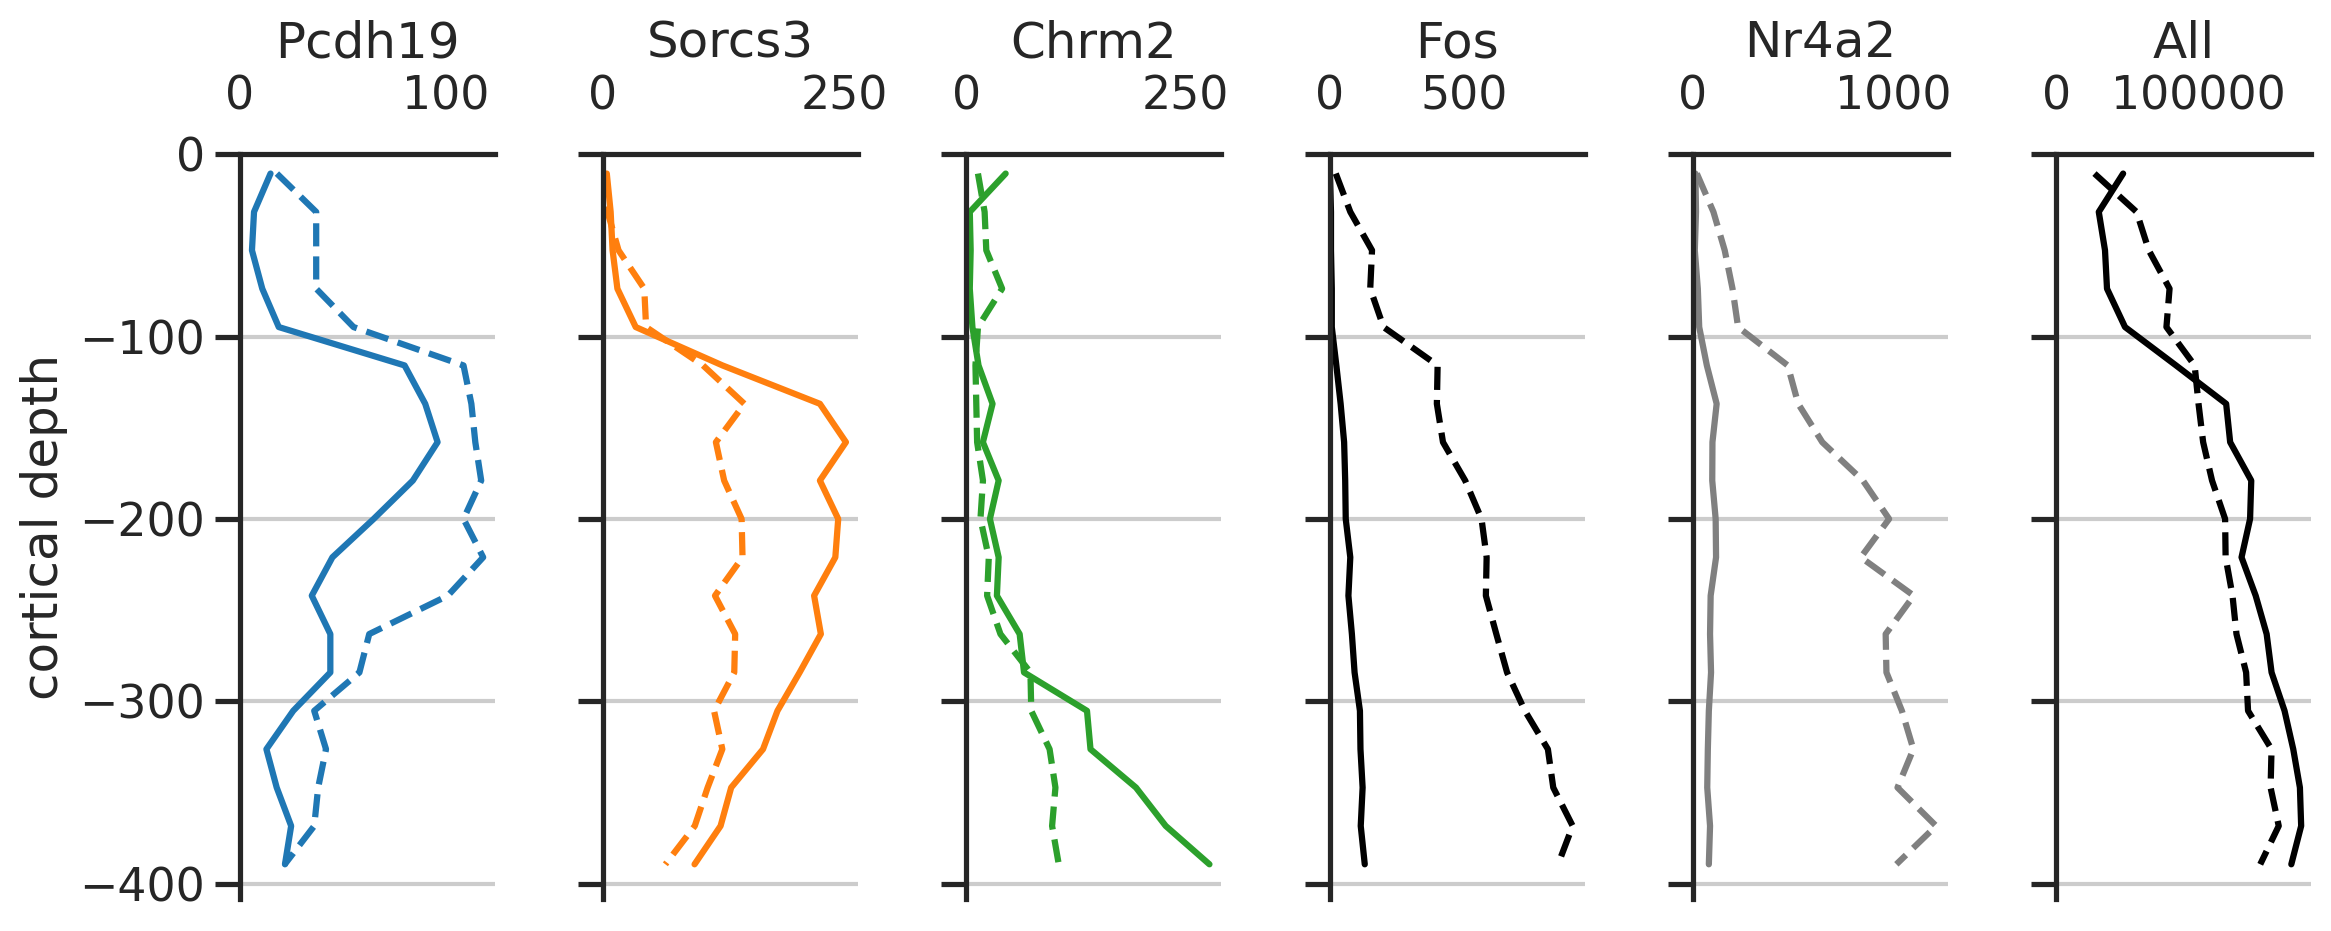

In [23]:
query_genes = ['Pcdh19', 'Sorcs3', 'Chrm2', 'Fos', 'Nr4a2', 'All']
samples = ['P28NR_pos', 'P28DR_ant']
colors = ['C0', 'C1', 'C2', 'k', 'gray', 'k']
linestyles = ['-', '--']
n = len(query_genes)
fig, axs = plt.subplots(1, n, figsize=(n*2,1*5), sharex=False, sharey=True)
ax = axs[0]
# ax.set_xlabel('norm counts')
ax.set_ylabel('cortical depth')

for j, gene in enumerate(query_genes):
    ax = axs[j]
    ax.set_title(gene)
    color = colors[j]
    for i, (name, linestyle) in enumerate(zip(samples, linestyles)):
        # color = colors[name]
        if gene == 'All':
            hist_norm = df_dbins[name].sum(axis=1)
        else:
            hist_norm  = df_dbins[name][gene]
        ax.plot(hist_norm, -midpoints,  
                color=color, label=name, linestyle=linestyle)
        sns.despine(ax=ax, top=False, bottom=True)
    # ax.tick_params(axis='x', rotation=90, size=2)
    ax.set_xlim(xmin=0)
    ax.set_ylim(ymax=0)
    ax.grid(visible=False, axis='x')

# ax.set_ylim([400,100])
# ax.legend()
fig.tight_layout()
plt.show()

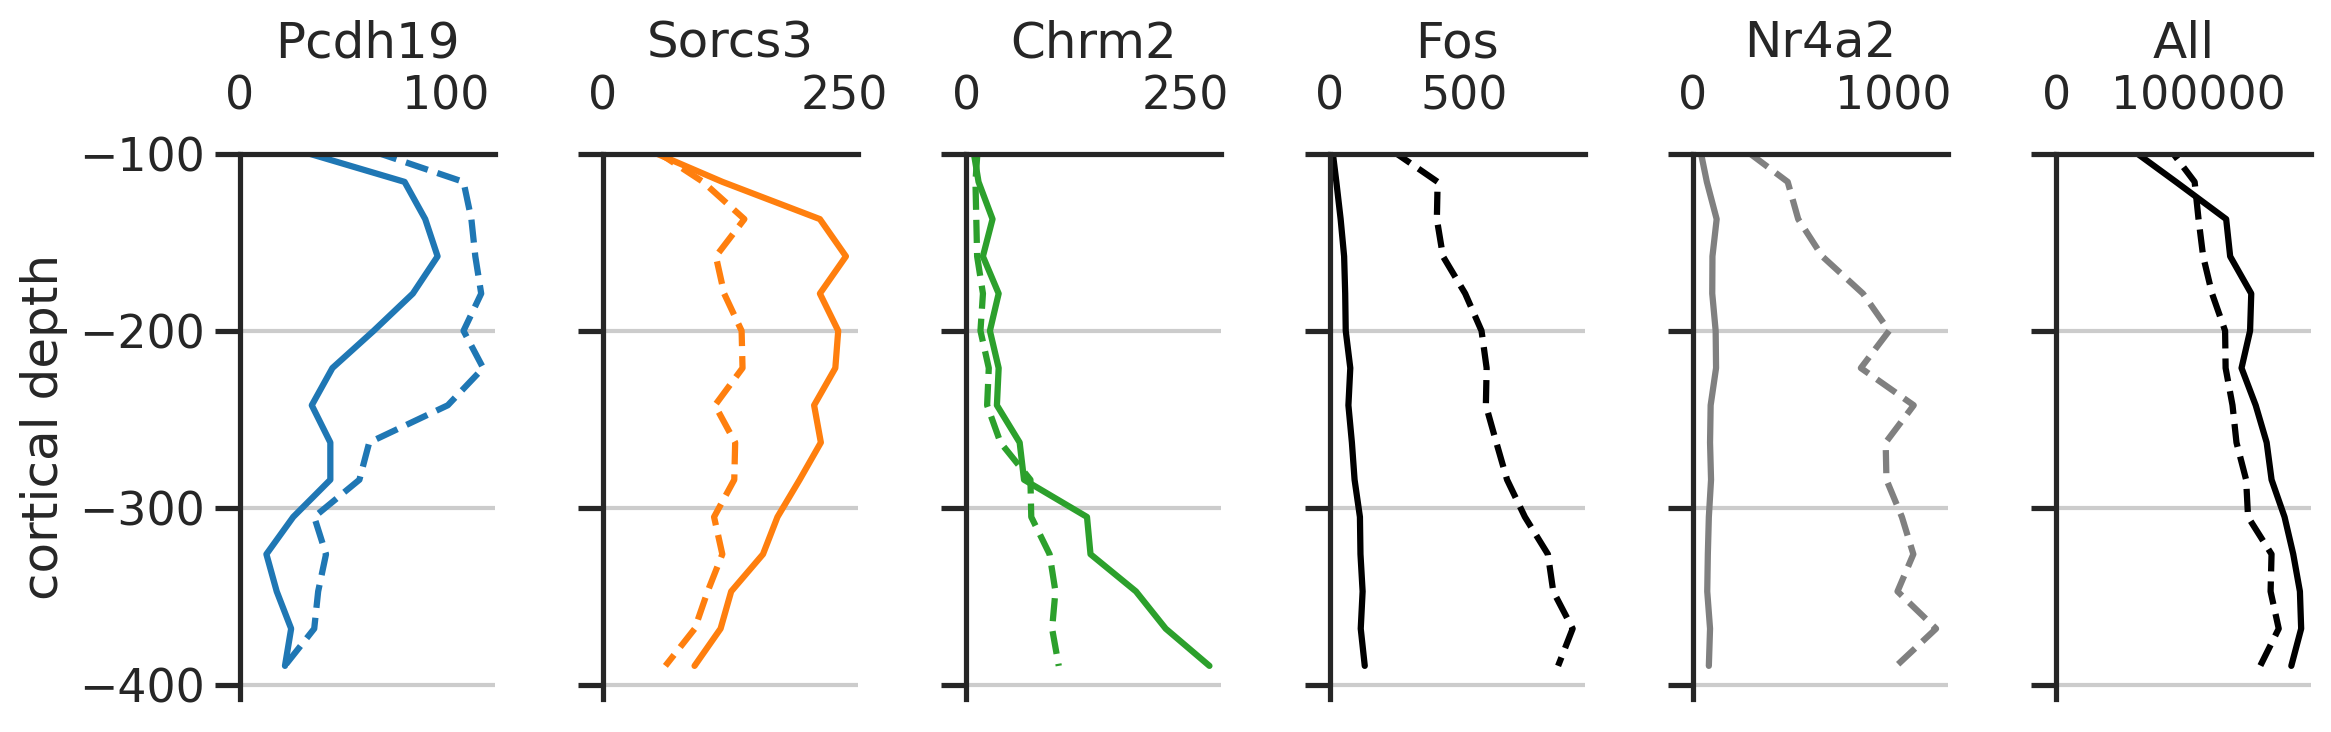

In [24]:

query_genes = ['Pcdh19', 'Sorcs3', 'Chrm2', 'Fos', 'Nr4a2', 'All']
samples = ['P28NR_pos', 'P28DR_ant']
colors = ['C0', 'C1', 'C2', 'k', 'gray', 'k']
linestyles = ['-', '--']
n = len(query_genes)
fig, axs = plt.subplots(1, n, figsize=(n*2,1*4), sharex=False, sharey=True)
ax = axs[0]
# ax.set_xlabel('norm counts')
ax.set_ylabel('cortical depth')

for j, gene in enumerate(query_genes):
    ax = axs[j]
    ax.set_title(gene)
    color = colors[j]
    for i, (name, linestyle) in enumerate(zip(samples, linestyles)):
        # color = colors[name]
        if gene == 'All':
            hist_norm = df_dbins[name].sum(axis=1)
        else:
            hist_norm  = df_dbins[name][gene]
        ax.plot(hist_norm, -midpoints,  
                color=color, label=name, linestyle=linestyle)
        sns.despine(ax=ax, top=False, bottom=True)
    # ax.tick_params(axis='x', rotation=90, size=2)
    ax.set_xlim(xmin=0)
    ax.set_ylim(ymax=-100)
    ax.grid(visible=False, axis='x')

# ax.set_ylim([400,100])
# ax.legend()
fig.tight_layout()
plt.show()

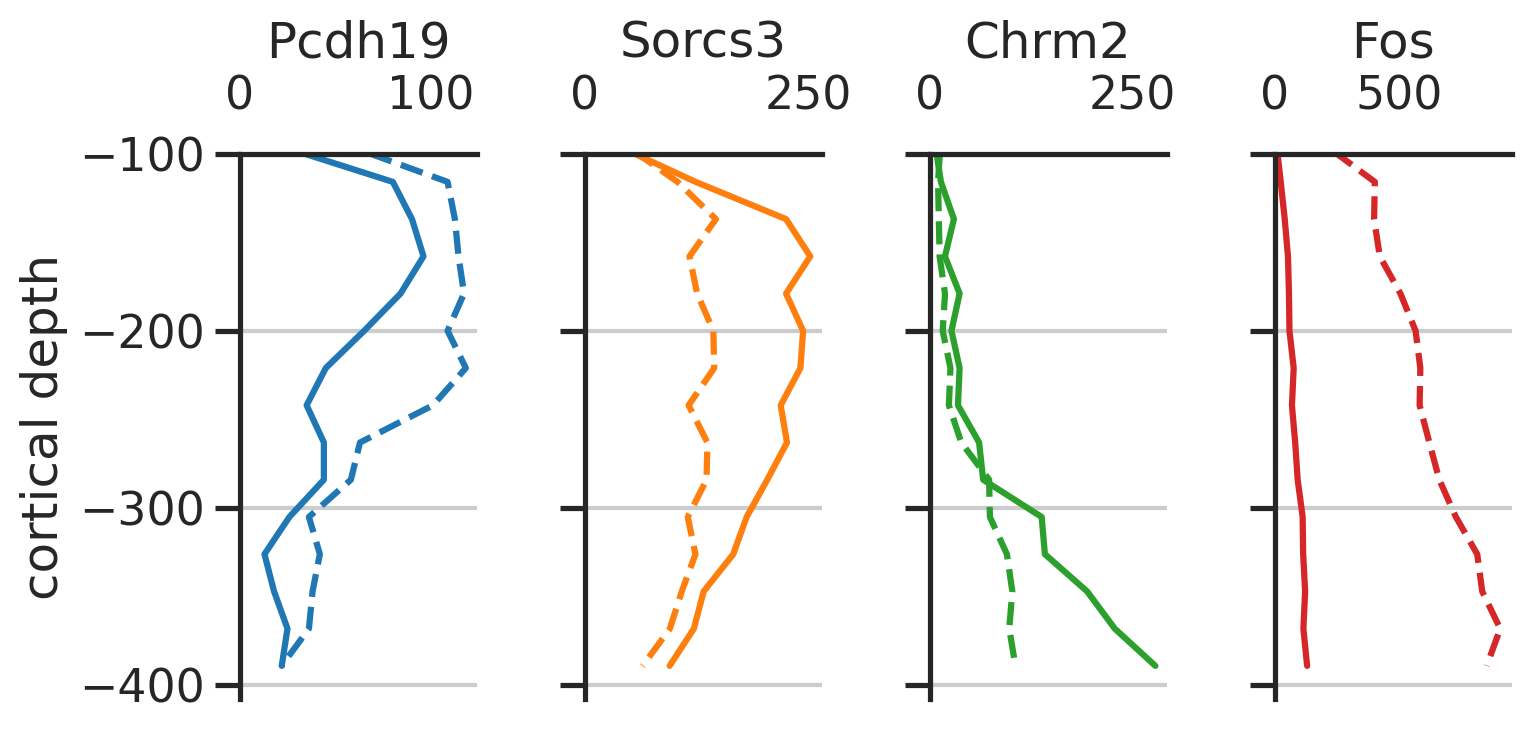

In [25]:
query_genes = ['Pcdh19', 'Sorcs3', 'Chrm2', 'Fos',] # 'All']
samples = ['P28NR_pos', 'P28DR_ant']
linestyles = ['-', '--']
fig, axs = plt.subplots(1, 4, figsize=(4*2,1*4), sharex=False, sharey=True)
ax = axs[0]
# ax.set_xlabel('norm counts')
ax.set_ylabel('cortical depth')

for j, gene in enumerate(query_genes):
    ax = axs[j]
    ax.set_title(gene)
    color = f'C{j}'
    for i, (name, linestyle) in enumerate(zip(samples, linestyles)):
        # color = colors[name]
        if gene == 'All':
            hist_norm = df_dbins[name].sum(axis=1)
        else:
            hist_norm  = df_dbins[name][gene]
        ax.plot(hist_norm, -midpoints,  
                color=color, label=name, linestyle=linestyle)
        sns.despine(ax=ax, top=False, bottom=True)
    # ax.tick_params(axis='x', rotation=90, size=2)
    ax.set_xlim(xmin=0)
    ax.set_ylim(ymax=-100)
    ax.grid(visible=False, axis='x')

# ax.set_ylim([400,100])
# ax.legend()
fig.tight_layout()
plt.show()

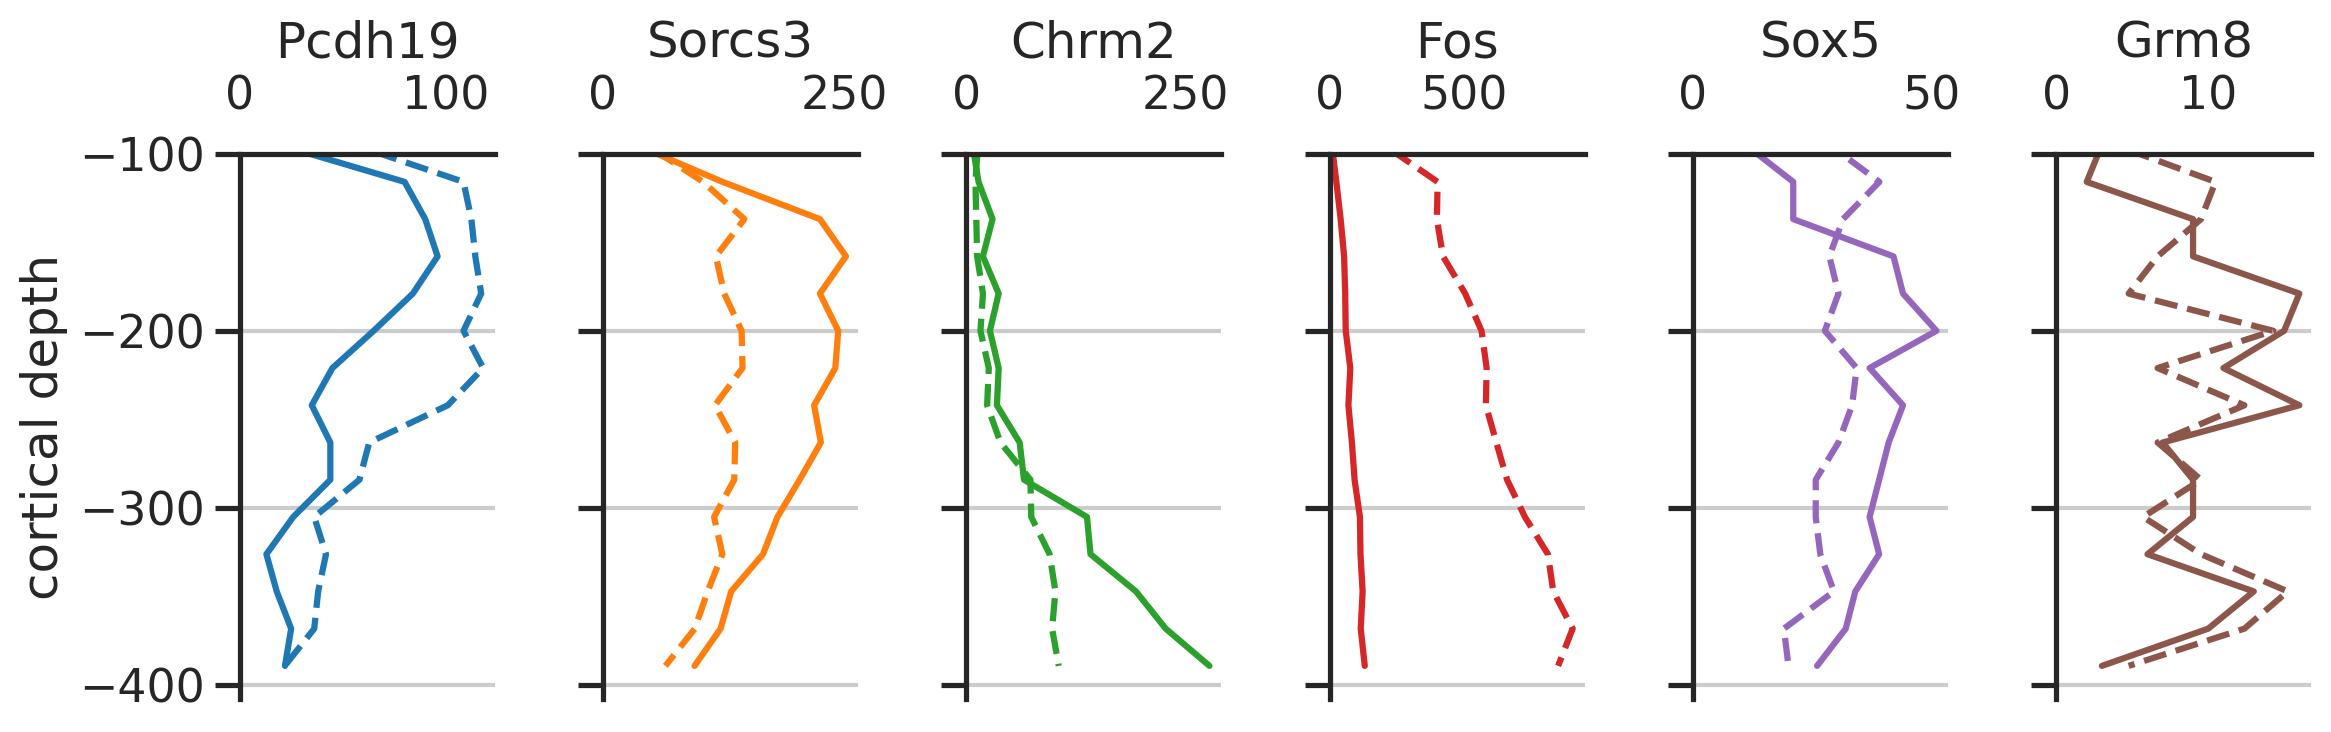

In [26]:
query_genes = ['Pcdh19', 'Sorcs3', 'Chrm2', 'Fos', 'Sox5', 'Grm8'] # 'All']
samples = ['P28NR_pos', 'P28DR_ant']
linestyles = ['-', '--']
fig, axs = plt.subplots(1, 6, figsize=(6*2,1*4), sharex=False, sharey=True)
ax = axs[0]
# ax.set_xlabel('norm counts')
ax.set_ylabel('cortical depth')

for j, gene in enumerate(query_genes):
    ax = axs[j]
    ax.set_title(gene)
    color = f'C{j}'
    for i, (name, linestyle) in enumerate(zip(samples, linestyles)):
        # color = colors[name]
        if gene == 'All':
            hist_norm = df_dbins[name].sum(axis=1)
        else:
            hist_norm  = df_dbins[name][gene]
        ax.plot(hist_norm, -midpoints,  
                color=color, label=name, linestyle=linestyle)
        sns.despine(ax=ax, top=False, bottom=True)
    # ax.tick_params(axis='x', rotation=90, size=2)
    ax.set_xlim(xmin=0)
    ax.set_ylim(ymax=-100)
    ax.grid(visible=False, axis='x')

# ax.set_ylim([400,100])
# ax.legend()
fig.tight_layout()
plt.show()

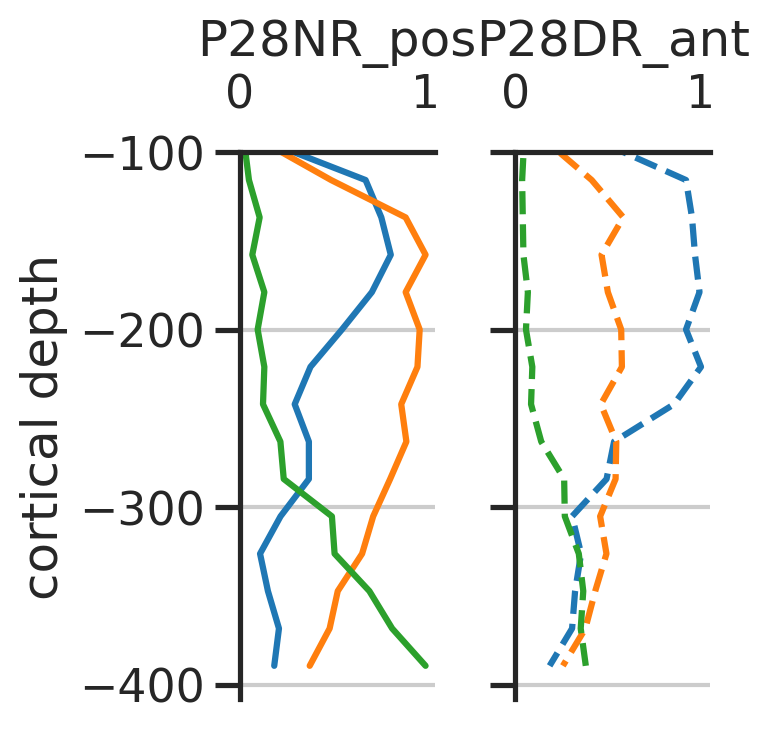

In [27]:
query_genes = ['Pcdh19', 'Sorcs3', 'Chrm2',] # 'Fos', 'All']
samples = ['P28NR_pos', 'P28DR_ant']
linestyles = ['-', '--']
fig, axs = plt.subplots(1, 2, figsize=(2*2,1*4), sharex=False, sharey=True)
ax = axs[0]
# ax.set_xlabel('norm counts')
ax.set_ylabel('cortical depth')


query_gene_max = []
for gene in query_genes:
    genemax = np.max([df_dbins[name][gene] for name in samples])
    query_gene_max.append(genemax)

for i, (name, linestyle) in enumerate(zip(samples, linestyles)):
    ax = axs[i]
    ax.set_title(name)
    for j, (gene, genemax) in enumerate(zip(query_genes, query_gene_max)):
        color = f'C{j}'
        if gene == 'All':
            hist_norm = df_dbins[name].sum(axis=1)
        else:
            hist_norm = df_dbins[name][gene]/genemax
        ax.plot(hist_norm, -midpoints,  
                color=color, label=name, linestyle=linestyle)
        sns.despine(ax=ax, top=False, bottom=True)
    ax.set_xlim(xmin=0)
    ax.set_ylim(ymax=-100)
    ax.grid(visible=False, axis='x')

# ax.set_ylim([400,100])
# ax.legend()
fig.tight_layout()
plt.show()

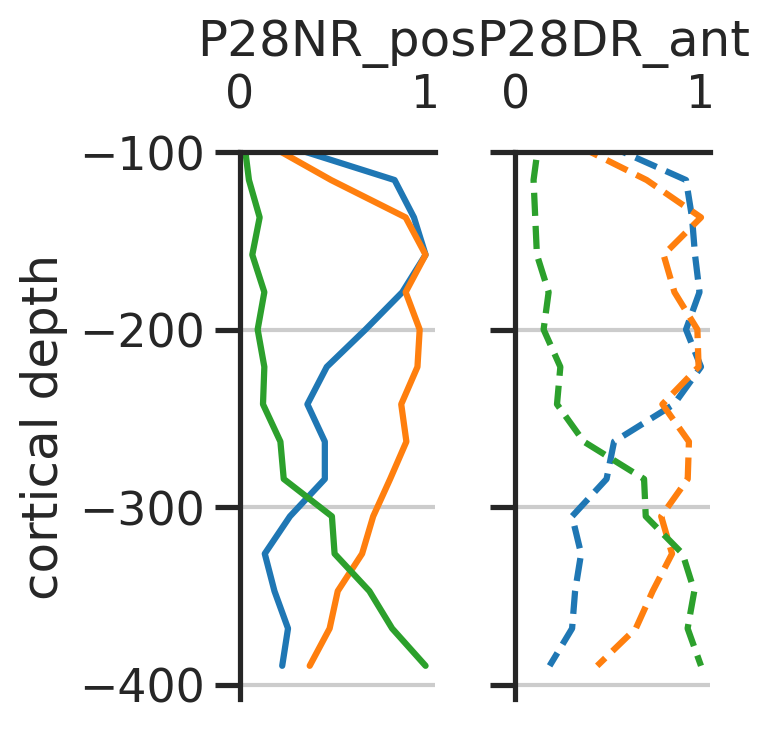

In [28]:
query_genes = ['Pcdh19', 'Sorcs3', 'Chrm2',] # 'Fos', 'All']
samples = ['P28NR_pos', 'P28DR_ant']
linestyles = ['-', '--']
fig, axs = plt.subplots(1, 2, figsize=(2*2,1*4), sharex=False, sharey=True)
ax = axs[0]
# ax.set_xlabel('norm counts')
ax.set_ylabel('cortical depth')

for i, (name, linestyle) in enumerate(zip(samples, linestyles)):
    ax = axs[i]
    ax.set_title(name)
    for j, (gene) in enumerate(query_genes):
        color = f'C{j}'
        if gene == 'All':
            hist_norm = df_dbins[name].sum(axis=1)
        else:
            hist_norm = df_dbins[name][gene]
            hist_norm = hist_norm/np.max(hist_norm)
        ax.plot(hist_norm, -midpoints,  
                color=color, label=name, linestyle=linestyle)
        sns.despine(ax=ax, top=False, bottom=True)
    ax.set_xlim(xmin=0)
    ax.set_ylim(ymax=-100)
    ax.grid(visible=False, axis='x')

# ax.set_ylim([400,100])
# ax.legend()
fig.tight_layout()
plt.show()

TypeError: list indices must be integers or slices, not str

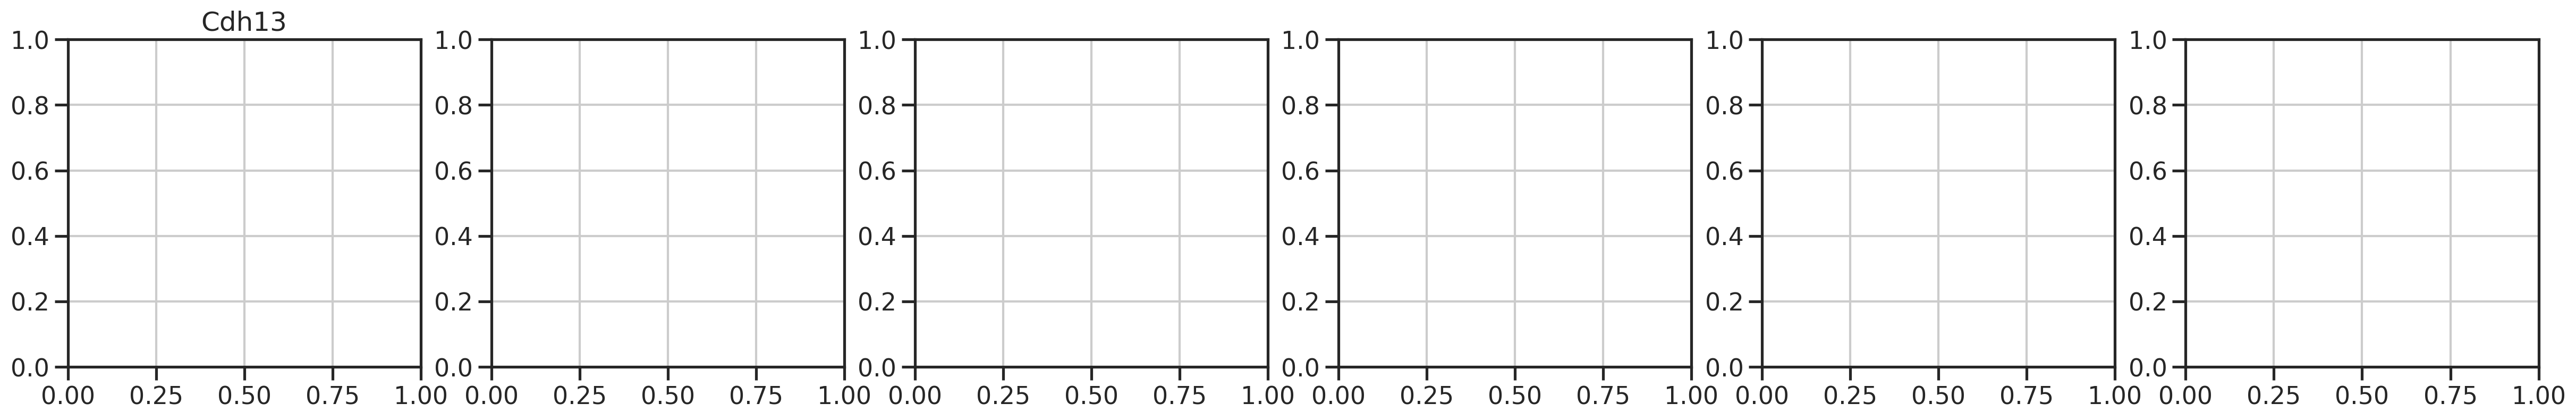

In [29]:
query_genes = ['Cdh13', 'Sorcs3', 'Sox5', 'Trpc6', 'Npas4', 'Chrm2']
n = len(query_genes)

fig, axs = plt.subplots(1, n, figsize=(n*5,1*4), sharex=True, sharey=False)
for j, gene in enumerate(query_genes):
    ax = axs[j]
    ax.set_title(gene)
    for i, name in enumerate(names):
        color = colors[name]
        hist_norm_fc  = df_dbin_fcs[name][gene]
        ax.plot(midpoints, hist_norm_fc, 
                color=color, label=name)
        sns.despine(ax=ax)

ax.legend()
plt.show()

In [ ]:
query_genes = ['Cdh13', 'Rfx3', 'Sema6a', 'Pcdh19', 'Gabrg3', 'Iqgap2', 'Grm8', 'Adamts2', 'Glis3']
n = len(query_genes)
fig, axs = plt.subplots(1, n, figsize=(n*5,1*4), sharex=True, sharey=False)
for j, gene in enumerate(query_genes):
    ax = axs[j]
    ax.set_title(gene)
    for i, name in enumerate(names):
        color = colors[name]
        hist_norm_fc  = df_dbin_fcs[name][gene]
        ax.plot(midpoints, hist_norm_fc, 
                color=color, label=name)
        sns.despine(ax=ax)

ax.legend()
plt.show()

In [ ]:
midpoints = np.mean([bins[:-1], bins[1:]], axis=0)
query_genesets = [agenes, bgenes, cgenes, iegs, up_agenes]# iegs]
titles = ['A genes', 'B genes', 'C genes', 'IEGs', 'A genes (up)']#, 'IEGs']
n = len(query_genesets)

fig, axs = plt.subplots(1, n, figsize=(n*5,1*4), sharex=True, sharey=False)
for j, geneset in enumerate(query_genesets):
    ax = axs[j]
    ax.set_title(titles[j])
    for i, (name) in enumerate(names):
        
        color = colors[name]
        hist_norm_fc  = (df_dbin_fcs[name][geneset]).apply(geometric_mean, axis=1) # mean(axis=1) # geometric mean
        ax.plot(midpoints, hist_norm_fc, 
                color=color, label=name)
        sns.despine(ax=ax)

ax.legend()


In [ ]:
midpoints = np.mean([bins[:-1], bins[1:]], axis=0)
query_genesets = [agenes, bgenes, cgenes, ]# iegs]
titles = ['A genes', 'B genes', 'C genes', ]#, 'IEGs']
n = len(query_genesets)

fig, axs = plt.subplots(1, n, figsize=(n*5,1*4), sharex=True, sharey=False)
ax = axs[0]
ax.set_ylabel('fold change\n(relative to NR mean)')
ax.set_xlabel('cortical depth')
for j, geneset in enumerate(query_genesets):
    ax = axs[j]
    ax.set_title(titles[j])
    for i, (name) in enumerate(names):
        
        color = colors[name]
        hist_norm_fc  = (df_dbin_fcs[name][geneset]).apply(geometric_mean, axis=1) # mean(axis=1) # geometric mean
        ax.plot(midpoints, hist_norm_fc, 
                color=color, label=name)
        sns.despine(ax=ax)

ax.legend()

In [ ]:
# try - Genes NR vs DR (MERFISH vs scRNA-seq)
# try - MERFISH cell typings on a triangle

# 20 EASI-FISH genes

In [ ]:
for i in range(5):
    query_genes = easifish_genes[i*4:(i+1)*4] 
    for name, df in dfs.items():
        abc = df[df['gene'].isin(query_genes)]

        fig, ax = plt.subplots(1,1,figsize=(12,3))
        sns.scatterplot(data=abc.sample(frac=1, replace=False), 
                        x='width', y='depth', hue='gene', hue_order=query_genes, 
                        s=4, edgecolor='none', ax=ax, )
        ax.set_aspect('equal')
        ax.axis('off')
        ax.set_title(name)
        ax.legend(bbox_to_anchor=(1,1))
        ax.invert_yaxis()

In [ ]:
query_genes = easifish_genes # ['Cdh13', 'Rfx3', 'Sema6a', 'Pcdh19', 'Gabrg3', 'Iqgap2', 'Grm8', 'Adamts2', 'Glis3']
n = len(query_genes)
nx = 5
ny = int((n+nx-1)/nx)

fig, axs = plt.subplots(ny, nx, figsize=(ny*6,nx*4), sharex=True, sharey=False)
for j, gene in enumerate(query_genes):
    ax = axs.flat[j]
    ax.set_title(gene)
    for i, name in enumerate(names):
        color = colors[name]
        # hist_norm_fc  = df_dbin_fcs[name][gene]
        hist_norm = df_dbins[name][gene]
        ax.plot(midpoints, hist_norm, 
                color=color, label=name)
        sns.despine(ax=ax)

ax.legend()
plt.show()